In [18]:
include("../Algebra/Gradients.jl")
include("../Algebra/Hamiltonians.jl")
include("../Algebra/Matrices.jl")
include("../Algebra/Propagators.jl")
include("../Amplitudes/Chebyshev.jl")
include("../Costs/Costs.jl")
include("../Gates/Xgate.jl")
using LinearAlgebra, Optim
using BenchmarkTools, Distributions

In [19]:
ω_c = 5
ω_q = 2
χ = 3e-3
N = 6
amp_c = 1
amp_q = 1

1

In [34]:
I_qubit = Matrix(I,2,2)
I_cavity = Matrix(I,N,N)
#X_gate = kron(x_gate(N, Array[[3,4], [5,6], [7,8]]), I_qubit)
X_gate = kron(x_gate(N, Array[[2,3]]), I_qubit)
X_gate = kron(x_gate(N, Array[[2,3],[4,5]]), I_qubit)

θ = π/2.5
RZ = kron(Rz(N, Array[[3,4]], θ/2), I_qubit)
RX = kron(Rx(N, Array[[3,4]], θ/2), I_qubit)

sx = kron(I_cavity, [0 1; 1 0])
sy = kron(I_cavity, [0 -1im; 1im 0])
# generating matrices
a,adag,sp,sm,sz = generate_matrices(N)

ψ_initial = zeros(N)
ψ_initial[1] = 1
ψ_initial = kron(ψ_initial/norm(ψ_initial), [0,1])

# ψ_initial = [0.0
# 0.042364880640716744
# 0.0
# 0.28885144075298463
# 0.0
# 0.16339860379664017
# 0.0
# 0.4589052841372305
# 0.0
# 0.5284511784719409
# 0.0
# 0.22306739569809422
# 0.0
# 0.3219611737913927
# 0.0
# 0.4947708459988468]
# ψ_final_u = Udue * ψ_initial
# ψ_final_x = RX * ψ_initial
# ψ_final_x_gate = X_gate * ψ_initial

12-element Vector{Float64}:
 0.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [21]:
disp(b) = exp(b * adag - b * a)
snap(x) = kron(Diagonal(exp.(-1im.*x)),I_qubit)

ECD(β) = exp(β/2 * adag - β'/2 * a) * sp + exp(-β/2 * adag + β'/2 * a) * sm
ROT(ϕ, θ) = exp(-1im * θ / 2 * ( sx * cos(ϕ) + sy * sin(ϕ) )) 

ROT (generic function with 1 method)

In [22]:
function snap_disp_classic(coefficients, unitary, N, blocks,disp,snap)

    αsi = coefficients[1: blocks]
    θs = coefficients[blocks + 1 : end]
    propagator = Matrix{ComplexF64}(I,N,N)
    q_d = Int(N/2)

    for i in 1:blocks
        propagator = propagator * disp(αsi[i]) * snap(θs[(i - 1) * q_d + 1 : i * q_d])
    end

    return 1 - norm(tr(propagator*unitary') / N)^2
    
end

function snap_disp_classic_gate(coefficients, unitary, N, blocks,disp,snap)

    αsi = coefficients[1: blocks]
    θs = coefficients[blocks + 1 : end]
    propagator = Matrix{ComplexF64}(I,N,N)
    q_d = Int(N/2)

    for i in 1:blocks
        propagator = propagator * disp(αsi[i]) * snap(θs[(i - 1) * q_d + 1 : i * q_d])
    end

    return propagator
    
end

function snap_disp_cost_gate(coefficients, unitary, N, blocks,disp,snap)

    L = length(coefficients)
    αs = coefficients[1: blocks]
    q_d = Int(N/2)

    θs = coefficients[blocks + 1 : end]

    propagator = Matrix{ComplexF64}(I,N,N)

    for i in 1:blocks
        propagator = propagator * disp(αs[i]) * snap(θs[(i - 1) * q_d + 1 : i * q_d]) * disp(αs[i])'
    end

    return 1 - norm(tr(propagator*unitary) / N)^2
    
end

function snap_disp_cost_gate_norm(coefficients, unitary, N, blocks,disp,snap)

    L = length(coefficients)
    αs = coefficients[1: blocks]
    q_d = Int(N/2)

    θs = coefficients[blocks + 1 : end]

    propagator = Matrix{ComplexF64}(I,N,N)

    for i in 1:blocks
        propagator = propagator * disp(αs[i]) * snap(θs[(i - 1) * q_d + 1 : i * q_d]) * disp(αs[i])'
    end

    return norm(propagator - unitary)
    
end

function snap_disp_cost_gate_opnorm(coefficients, unitary, N, blocks,disp,snap)

    L = length(coefficients)
    αs = coefficients[1: blocks]
    q_d = Int(N/2)

    θs = coefficients[blocks + 1 : end]

    propagator = Matrix{ComplexF64}(I,N,N)

    for i in 1:blocks
        propagator = propagator * disp(αs[i]) * snap(θs[(i - 1) * q_d + 1 : i * q_d]) * disp(αs[i])'
    end

    return opnorm(propagator - unitary)
    
end

function snap_disp_cost_state_prep(coefficients, N, ψ_n, ψ_m, blocks)

    αs = coefficients[1: blocks]

    θs = coefficients[blocks + 1 : end]

    propagator = Matrix{ComplexF64}(I,N,N)

    for i in 1:blocks
        propagator = propagator * disp(αs[i]) * snap(θs[(i - 1) * N + 1 : i * N]) * disp(αs[i])'
    end

    return 1 - norm(ψ_m' * propagator * ψ_n)^2
    
end


snap_disp_cost_state_prep (generic function with 1 method)

## trace

In [37]:
costs = []
it_costs = []
for blocks in 2:1:4
    for iteration in 1:20
        println("blocks: ", blocks," iterations :", iteration)
        coefficients_initial = zeros((N + 1 ) * blocks)
        coefficients_initial[1: blocks] = rand(blocks)*2 .-1
        coefficients_initial[blocks + 1:end] = rand(N*blocks) * 2 * pi .- pi
        f(x) = snap_disp_cost_gate(x, X_gate, N * 2, blocks, disp,snap)
        #g(x) = snap_disp_cost_state_prep(x, N * 2, ψ_initial, ψ_final_x_gate, blocks)
        res = Optim.optimize(f, coefficients_initial , LBFGS(), Optim.Options(show_trace=true, show_every=100))
        push!(it_costs,Optim.minimum(res))
        println(Optim.minimum(res))
        println(Optim.minimizer(res))
    end
    println(it_costs)
    println(minimum(it_costs))
    push!(costs,minimum(it_costs))
end

blocks: 2 iterations :1
Iter     Function value   Gradient norm 
     0     9.492509e-01     6.779532e-02
 * time: 0.00026988983154296875


0.24949121077947956
[-0.08778065869031831, -0.37278646449916936, 0.9367891301721443, -2.204803528505678, 4.078381783933515, 0.936789132853773, 0.9367891230290383, 0.9367891139603264, 1.8434018822199583, 1.8434018742764664, -1.298190772668625, -1.2981907765854672, 1.8434018820279001, 1.8434018904797045]
blocks: 2 iterations :2
Iter     Function value   Gradient norm 
     0     9.348557e-01     2.691737e-01
 * time: 4.601478576660156e-5


0.24949121077948055
[-0.372786464385881, -0.0877806598753854, 2.277484070392938, 2.2774839955399386, -0.8641086577799161, -0.8641086319900011, -4.005701247692348, 2.277484047062671, 3.328511585483014, 0.1869189831100085, 0.1869189987123807, -2.954673707940062, 3.328511569190139, -2.9546736991866913]
blocks: 2 iterations :3
Iter     Function value   Gradient norm 
     0     9.967191e-01     1.053242e-01
 * time: 5.602836608886719e-5


   100     3.837885e-01     1.364175e-06
 * time: 0.40167999267578125


0.383788547633639
[-39.98178618668674, -5.387340373413198, 2.5658460856840337, 5.79712115905932, 5.847348008951147, 2.7008449244065074, -0.39335014159144516, -6.6688567036631134, 0.13175789153252127, -6.228280576966134, 9.431716746887236, 3.1256113138713006, -3.1680420622059837, -3.1978661097404353]
blocks: 2 iterations :4
Iter     Function value   Gradient norm 
     0     9.648758e-01     1.724743e-01
 * time: 5.793571472167969e-5


0.36989664463864225
[0.6800585391040963, -0.2892761383023489, -3.392037299528991, -3.060875224422507, -2.2550408329814267, -1.7567998912419067, 4.047445870066306, -0.5744304418431465, 1.3332502361350977, 2.9196882763681598, 1.2353137186759728, 2.002427861068438, 0.4637953655086874, 0.30365456832692184]
blocks: 2 iterations :5
Iter     Function value   Gradient norm 
     0     9.898167e-01     7.768351e-02
 * time: 2.193450927734375e-5


0.27995845570181077
[0.1622965884847616, 0.64731222169072, 2.732565789577069, 2.732565814108144, 2.7325658083493374, -0.40902686405471544, -0.4090268611466983, -0.40902686165661556, 0.9666590795230431, 0.966659050312219, -2.174933597517325, -2.174933611029572, -2.174933603640207, 0.9666590457849014]
blocks: 2 iterations :6
Iter     Function value   Gradient norm 
     0     9.924207e-01     7.453472e-02
 * time: 2.002716064453125e-5


0.36942740934838525
[-0.048647864022944534, -1.1419416356165908, 1.5811638747837886, -1.5604288376353175, -1.5604287820818743, -1.5604288371204478, -1.5604288039767644, -4.702021463581344, -2.3603041002313083, -2.36030408884595, 3.9228812440063345, -2.360304022132848, 0.7812885869742257, 0.7812885932842449]
blocks: 2 iterations :7
Iter     Function value   Gradient norm 
     0     9.574769e-01     3.414530e-02
 * time: 2.09808349609375e-5


0.36989664463864225
[0.6800585387486161, -0.28927613827265986, -2.391403039688193, -2.7225651177412473, 2.7547857868278713, 2.2565448613057844, 2.7354843865616805, 1.0741754105396717, 3.0219522407924555, 1.4355141932551436, 3.119888762517762, -3.930410695183397, -2.3917781832386864, 4.051547906270813]
blocks: 2 iterations :8
Iter     Function value   Gradient norm 
     0     9.730138e-01     1.888169e-01
 * time: 2.193450927734375e-5


0.3392436421354603
[1.127358172793461, -1.3906347782844553, -2.992367301028026, -2.6131447462445263, -2.986953200304177, 3.3815869058966896, 0.17055015514636548, 2.6506335572678945, -4.9261452133127035, 3.800580518258804, 3.432126185211188, -2.502042601636664, 3.762448310203421, -2.4618857182853793]
blocks: 2 iterations :9
Iter     Function value   Gradient norm 
     0     9.855741e-01     1.378603e-01
 * time: 2.288818359375e-5


0.23228971510191943
[-1050.662709315552, -6995.997603150758, -596.739296611923, 515.3845027564223, -951.7392664761129, -1036.5622681357945, 634.7650235803204, 1439.0127429085778, -224.90911827594394, -23.847188439581796, 240.0465944637248, 1088.2766109468591, -510.7940497386637, -564.2011248535482]
blocks: 2 iterations :10
Iter     Function value   Gradient norm 
     0     9.992726e-01     2.434496e-02
 * time: 2.002716064453125e-5


0.37026631622834083
[-0.7259653281936348, 1.125249134818261, -1.4609501319942084, -1.0676821253791124, 4.461146612913152, -2.417130836596371, 4.580647291450415, -2.0031423783661193, 4.675318012135756, -1.809777211684518, -2.0339254687227166, 5.052055412636283, -4.946163258755918, 0.42964698425358006]
blocks: 2 iterations :11
Iter     Function value   Gradient norm 
     0     9.016766e-01     8.585389e-02
 * time: 6.794929504394531e-5


0.35928288317196133
[-0.02478125888439792, -0.633660511612872, -1.8764664313684802, 1.2651262048336145, 1.2651262091257405, -1.8764665020598896, -1.876466492601027, 1.2651261875627926, -2.147893580767871, -2.1478935836424697, 0.9936991087076261, 0.9936990882415503, 0.9936990940524684, -2.1478935252222167]
blocks: 2 iterations :12
Iter     Function value   Gradient norm 
     0     9.724596e-01     2.956894e-01
 * time: 2.002716064453125e-5


0.279958455701811
[0.6473122220893726, 0.1622965878139306, 0.020893057198633755, 0.020893054499985582, -3.1206995995439395, -3.1206995943302984, 3.1624857162130895, 0.0208930427571133, 1.5359973154319853, 1.5359973056098999, 1.5359973235303097, -1.6055953276100747, -1.6055953241569516, -1.6055953275377879]
blocks: 2 iterations :13
Iter     Function value   Gradient norm 
     0     9.612839e-01     2.206082e-01
 * time: 2.002716064453125e-5


0.24949121077947978
[-0.3727864638483733, -0.08778065897220433, -0.6805035805666148, -0.6805035836161959, 2.4610890578872806, 2.4610890646528527, -0.6805036002307733, -0.6805036026663495, 0.03375670502669255, 3.1753493702149083, 3.175349387935932, 0.03375672571681949, 0.03375672949779932, 0.03375673585135493]
blocks: 2 iterations :14
Iter     Function value   Gradient norm 
     0     9.979475e-01     1.115460e-01
 * time: 1.9788742065429688e-5


0.30360537366493867
[8.679535554814546, 1.1252349301938482, -1.4773718868005332, 3.4291074101837284, -2.4399972945659285, 2.3464192976113933, -2.4597960235751213, 2.4912955192169237, -1.9293793603735165, 2.9443321023842044, -2.932437059595847, -1.940714128840355, -0.14337790899545413, -1.1897442936906013]
blocks: 2 iterations :15
Iter     Function value   Gradient norm 
     0     9.798228e-01     1.073156e-01
 * time: 4.696846008300781e-5


0.3544167895850473
[1.1217567777434017, -0.30753137574246836, -0.4972582798916871, -0.02783420481427622, -0.137079250420764, 0.36268301596283514, -3.9171191013994964, 1.6558963723698208, -0.4215013536215397, 0.9249579158808983, -0.11625836671000499, 0.18514548638719963, -0.9260173675384565, -0.3792144372108749]
blocks: 2 iterations :16
Iter     Function value   Gradient norm 
     0     9.870530e-01     3.323401e-02
 * time: 2.002716064453125e-5


0.303339318963473
[-5.445189118930519, 4.826652500737028, 0.8779622092812599, 0.8779621419028067, 4.019554863502707, 4.019554764569409, 4.019554834678213, -5.405223034678525, -9.85708486158812, -0.4323068441741732, -0.43230689914642023, 2.709285694451238, 2.7092857349491695, 5.850878505762669]
blocks: 2 iterations :17
Iter     Function value   Gradient norm 
     0     9.997992e-01     8.046241e-03
 * time: 4.1961669921875e-5


0.1955012514720853
[-4.707868615209508, 0.40156310727609096, 0.8526192621128206, 0.8526194541718038, 0.8526194115141827, 3.9942120699792434, -2.288973232906571, 0.8526193977356359, 4.464073000328985, -1.819112506246243, 1.322480163009194, 1.3224801961808634, -1.8191124388992455, -1.819112454329286]
blocks: 2 iterations :18
Iter     Function value   Gradient norm 
     0     9.905555e-01     1.906142e-02
 * time: 2.193450927734375e-5


0.36989664463864225
[-0.2892761375256793, 0.6800585406221611, -4.178387831826881, -2.591949777859879, -4.276324355109598, 2.7739750869014173, 1.23534261352883, 1.075201828111283, -2.3047650306695715, 4.309582346698713, -1.167768582584284, -0.6695276380115486, -1.1484671773984938, 0.5128418412983264]
blocks: 2 iterations :19
Iter     Function value   Gradient norm 
     0     9.181929e-01     3.660737e-01
 * time: 2.193450927734375e-5


0.30883184802781494
[-0.5419711705742065, -0.2261453197023571, -0.06491713999134908, -0.06491716920374448, -3.2065098561890735, 3.0766755097928415, 3.076675454763173, -3.2065098450185627, -2.897523992501034, 0.24406865778862175, 0.24406868553724562, 3.38566133481661, 0.24406868528708664, 0.244068671771897]
blocks: 2 iterations :20
Iter     Function value   Gradient norm 
     0     9.657626e-01     3.002543e-01
 * time: 2.288818359375e-5


0.24949121077948
[-0.372786464046509, -0.08778065927814492, 5.986670814789436, -0.29651449252985596, -3.438107150196983, -3.4381071472945575, -0.29651449593839957, -0.29651449235875155, -1.2693450711670506, -4.410937718205542, 1.8722475868704036, -1.2693450666241208, 5.01384024081318, -1.2693450681757301]
Any[0.24949121077947956, 0.24949121077948055, 0.383788547633639, 0.36989664463864225, 0.27995845570181077, 0.36942740934838525, 0.36989664463864225, 0.3392436421354603, 0.23228971510191943, 0.37026631622834083, 0.35928288317196133, 0.279958455701811, 0.24949121077947978, 0.30360537366493867, 0.3544167895850473, 0.303339318963473, 0.1955012514720853, 0.36989664463864225, 0.30883184802781494, 0.24949121077948]
0.1955012514720853
blocks: 3 iterations :1
Iter     Function value   Gradient norm 
     0     9.868974e-01     1.483224e-01
 * time: 5.602836608886719e-5


   100     5.919261e-02     6.485830e-03
 * time: 0.6929969787597656


   200     2.138859e-02     7.528296e-05
 * time: 1.4045228958129883


0.021388578446275397
[0.20883028454703328, -0.22867629642777088, 0.20883028784954957, 4.910376873791324, -1.2285544614320765, 0.9438148318118726, -0.02702106818019613, 1.9535190579277726, -5.874126921989637, -6.776125626408037, -0.1910914340157776, -2.2141043834790697, -2.736147988468517, 2.570256668543111, 7.590137783536132, -2.7811222389556756, 3.6463169674366607, -0.4644990449368083, -1.4353349180044808, 0.5452052352501273, -0.9992554209269284]
blocks: 3 iterations :2
Iter     Function value   Gradient norm 
     0     8.693683e-01     2.227112e-01
 * time: 2.193450927734375e-5


   100     1.855421e-01     1.499559e-07
 * time: 0.6928379535675049


0.18554209019503265
[0.4847884562604096, -0.2571187995311012, -1.0884086618327784, 2.957423892382475, 3.1875249596372783, 1.0897865023550588, 0.9051344436050618, -4.435164873086945, 1.334498872877797, 0.977515878666731, -0.6159176356976086, -0.03694903073922224, -1.2443968667018745, 1.1042742925645395, 1.6793530995379427, 1.0847839006703779, -4.975788660263984, 2.2847103387201186, 2.197158587797667, 3.185956727945287, -3.634128530206221]
blocks: 3 iterations :3
Iter     Function value   Gradient norm 
     0     9.330574e-01     4.472693e-01
 * time: 2.09808349609375e-5


   100     2.140418e-01     2.679653e-04
 * time: 0.6653990745544434


   200     2.135962e-01     1.878019e-04
 * time: 1.352452039718628


   300     2.135494e-01     7.443235e-06
 * time: 2.08815598487854


0.21354938711137494
[0.39091701422214753, 0.11014856440644626, 0.07454423444577236, 0.4160273387865674, 0.41602717004411466, -2.7255654385893386, 3.557619696730287, 0.416027003720013, 0.41602727326378613, 1.1599001459519533, 4.301492180890978, 4.3014922087408305, 1.1598984643376156, 1.1598983228081987, -5.123288827492008, 1.8310284714456309, -1.3105634037372385, -1.3105634453608161, -1.3105622749067345, -1.3105621475054536, 1.831032292675228]
blocks: 3 iterations :4
Iter     Function value   Gradient norm 
     0     9.552564e-01     2.817435e-01
 * time: 2.5987625122070312e-5


0.24417800990609928
[0.36335256635234, 0.7310052927809015, -1.0065193136667685, -3.2478875356047805, 2.3638240835264996, 1.6749847204660233, -3.48290691122874, -1.264650371702892, -1.5663830641015721, 1.632849787397407, -4.060635885169039, 0.9877561917448601, -0.3545410211489401, 0.11948182202429176, 2.921682018807291, 2.794139844819348, 2.871798740612829, 2.254269709813273, -3.246999191168453, -2.0394424133103803, -3.234279604201218]
blocks: 3 iterations :5
Iter     Function value   Gradient norm 
     0     9.929485e-01     1.408398e-01
 * time: 2.2172927856445312e-5


   100     2.338821e-02     1.086834e-02
 * time: 0.693446159362793


0.023248997451594478
[-0.23052519486577605, 0.19208649811026976, -0.2305251972386783, 0.21355292335594783, 5.501256042357001, 1.4602743029365999, 0.5002778224544796, 2.089662099695297, -3.91719015724385, 0.4945527607124967, -6.735943733546326, -2.3094567132128803, 3.334225040783585, 1.893376081347955, 2.63845919290848, -0.4514909787528695, -1.4469731737586904, 0.7952303961418041, -0.16476603243452564, -4.858567056324173, 1.7009513176264477]
blocks: 3 iterations :6
Iter     Function value   Gradient norm 
     0     9.767112e-01     1.718334e-01
 * time: 5.1021575927734375e-5


0.18554209019503232
[0.48478845471836274, -0.2571187992644692, -1.0884086588782942, 1.0528249084541892, 0.8227238247272239, 2.9204623016591125, -3.178070944976489, 2.162228363473953, 2.6757498869991108, 0.0688188118726107, 1.6622523091946506, 1.0832837099588497, -3.992453732407186, -0.057939620160540155, -0.6330184274662812, 3.8413292759320137, -2.6644687649571823, 2.641402865804157, 2.7289546133302554, 1.7401564610806248, 2.277056423458503]
blocks: 3 iterations :7
Iter     Function value   Gradient norm 
     0     9.578322e-01     1.672877e-01
 * time: 4.601478576660156e-5


   100     1.483959e-01     3.568416e-04
 * time: 0.7061669826507568


0.14839477580654692
[-0.32481096266519566, 1.3753251177255843, -0.14661936303871426, -1.179900177477175, 4.070845468894584, -0.6002820827224248, -0.1755120671458635, 2.3919551359839075, 1.5391104203311647, -0.19261780565576464, -0.011282173716087803, -0.8408997482770336, -1.036902351986385, -0.5560798615695633, -2.029824410982633, 3.2901760337496695, 1.662315773837694, -3.595436915725549, -0.9867840573933986, -0.1519713722024051, 0.05641875762819375]
blocks: 3 iterations :8
Iter     Function value   Gradient norm 
     0     9.164332e-01     3.077137e-01
 * time: 2.09808349609375e-5


   100     2.030129e-01     1.701167e-05
 * time: 0.6638360023498535


0.2030129290437459
[-0.6569163805993277, -0.17654558552914915, 0.08225308433290847, -1.028967082647175, -1.177158070019463, -3.3146118434595273, 2.810844601764113, 3.0234299212778963, 0.7392667979442931, 1.5681020766299854, -2.2170322069344515, -3.3738982871953334, -0.820576841509047, 4.478515078804959, -1.745382036956963, -0.18902538283444079, 0.11858926281842129, 1.2139214014055084, 0.877792602441995, 1.5902763187360252, -0.8575943522409656]
blocks: 3 iterations :9
Iter     Function value   Gradient norm 
     0     9.988597e-01     4.607176e-02
 * time: 3.0040740966796875e-5


   100     1.186996e-01     2.328022e-02
 * time: 0.6824169158935547


   200     1.181090e-01     1.189725e-07
 * time: 1.3817760944366455


0.11810897189034841
[1.1503168438958853, -0.12241087613337445, -0.6546532856571325, 0.87207928345095, 0.8720793591876972, 0.8720792652684843, 0.8720791606621053, -2.2695138517120346, 0.8720791454695113, -1.3930983742747138, 1.7484943344601112, 1.7484943270841633, 1.748494750675814, 1.7484946016374026, -4.534690945848353, -2.1217347159404474, -2.1217346174667315, -5.263327191819826, 1.0198579422830079, 1.0198579887767008, 1.0198576087072921]
blocks: 3 iterations :10
Iter     Function value   Gradient norm 
     0     8.949332e-01     4.745769e-01
 * time: 2.09808349609375e-5


   100     2.024134e-01     2.783233e-07
 * time: 0.6712131500244141


0.2024134299696737
[-0.8896330279220853, 0.1541989668035503, 0.5921361868425332, 2.2199949334977114, 1.8518298256433676, 2.0750325713864153, 0.9464439069508509, 0.7730548228576474, 1.0829156792982784, -1.2612489059743865, -0.04063669316298077, 0.4294543389200999, -1.8049918930259377, -1.0229968770055615, 3.388680097177666, 4.368425866939774, -2.6401157952371106, -0.770128366475536, -0.4859883521200752, 0.1763318875177496, 1.663530321013359]
blocks: 3 iterations :11
Iter     Function value   Gradient norm 
     0     9.838791e-01     2.264176e-01
 * time: 6.198883056640625e-5


   100     1.658492e-01     6.431501e-05
 * time: 0.7013809680938721


0.16584912494575044
[-0.3135704711279418, 0.11853988324933007, 0.4758379442023875, 2.529704681559595, -3.180998492576228, 3.1874003307606715, -2.7401966837246023, 1.8556784741159584, 2.1934506943972467, -2.7933484112397813, 2.4969734854896473, 2.2667676053393033, -0.11019886167984358, 0.3838880413347192, -1.324460660775939, 2.296887525591921, 2.854523416754129, -0.23899333188643182, -0.016540016430276343, 1.3011223876023192, -4.407745840761833]
blocks: 3 iterations :12
Iter     Function value   Gradient norm 
     0     9.556978e-01     2.446030e-01
 * time: 4.696846008300781e-5


   100     1.240913e-01     3.788630e-03
 * time: 0.7036371231079102


0.12390257581690967
[1.8041418335001647, 1.2227232490355595, -0.8557720945686265, -1.6266108128220154, 0.1020280901423008, -0.6626489031404177, 3.2522470251284266, -5.506801583988289, 2.119649389590607, 1.6516225917356, 2.156610065889816, 1.778314021617243, -0.0245235070088416, 3.0273255439957785, -1.7202348120853823, 1.9158530662580906, -0.9233050523926233, 1.5406280711394218, -2.4697180286251257, 1.6400238908792224, 3.4983687969072856]
blocks: 3 iterations :13
Iter     Function value   Gradient norm 
     0     9.732730e-01     2.190635e-01
 * time: 2.5033950805664062e-5


   100     1.920859e-01     1.501682e-07
 * time: 0.6559219360351562


0.192085925082781
[-0.15093037062784667, 1.1617011802195247, -0.527302993013556, 0.38034930107255954, -1.6977778271457615, -1.295568772447541, -0.14416383201788568, -0.5477480938729765, -1.0465475920962186, -3.811874436997767, 2.4208102055322347, -3.747970258807521, 1.8013933952776875, -1.8390372840577356, 1.6019049521539415, -4.146229884503951, 1.4788473354709004, 3.6238112183414875, -2.07020487058676, 3.596990892027139, -3.2284829355093394]
blocks: 3 iterations :14
Iter     Function value   Gradient norm 
     0     9.698928e-01     9.725222e-02
 * time: 2.4080276489257812e-5


   100     7.533695e-02     6.428510e-04
 * time: 0.6933989524841309


0.07533631450490152
[0.7510276611593859, -0.07773002490059985, 0.7510276611937794, 0.9603541461655393, 4.078545890134055, -2.170831617512823, -5.410836023220152, -2.1149960415098352, -3.7979067576327856, -2.955755459470054, 3.306304370415738, 3.350553376750781, 3.5582646643336275, -3.0800173460917724, 0.23862081546029534, -1.9711963672454806, 1.1469953688790304, 1.1808032756169409, -2.0592011803901915, 1.2366387982797176, -0.4462720277730188]
blocks: 3 iterations :15
Iter     Function value   Gradient norm 
     0     9.499926e-01     2.025895e-01
 * time: 2.8133392333984375e-5


   100     1.269674e-01     2.821497e-02
 * time: 0.697735071182251


0.11810897189034608
[1.1503168429405948, -0.12241087971665288, -0.6546532863173817, 4.736188729444089, -1.5469965703387396, -1.5469965638164864, -1.5469965855037815, 1.5945960384671112, -1.5469966222796232, -1.475437410542174, -4.617030033132815, 1.6661552764267047, -4.617029995917169, 1.6661552739560896, 1.66615529019675, 2.9507832577331907, 2.950783292723864, -0.1908093837350569, -0.19080938809557607, -0.1908094281274934, -6.473994719880098]
blocks: 3 iterations :16
Iter     Function value   Gradient norm 
     0     9.652236e-01     1.970585e-01
 * time: 2.002716064453125e-5


   100     3.831889e-02     1.036233e-03
 * time: 0.7197799682617188


0.038318093923130236
[-0.2002430620131897, -0.55396610832507, -0.20024306058771554, 0.892504978225629, 2.86245647769374, -3.080874530540287, -5.240715812393026, 2.4029296579645067, -0.9475453241254793, -1.8665581471980914, -3.0377859283903654, -0.35227627409840284, 0.4772102987515875, 2.101814777407805, 1.5341502859417186, 1.1799131604974225, 3.149864645384452, -2.7934663765405903, 1.3298776160092762, -3.5928475388478907, -0.6601371852110186]
blocks: 3 iterations :17
Iter     Function value   Gradient norm 
     0     8.729893e-01     2.760591e-01
 * time: 2.288818359375e-5


   100     3.887379e-02     4.388479e-03
 * time: 0.6941149234771729


0.023248997451594478
[-0.23052520161627782, 0.1920864980946976, -0.23052519321478887, -6.6936927851932015, -1.405989621394407, 0.8362139112176157, -0.12378249993746888, 1.4656017990943555, 1.7419348314738947, 0.5066261908153257, -0.44068500559998003, -2.297383259281186, -2.9368868295731816, -4.377735771287408, 2.650532633531919, 4.131981300337551, 3.1364991086908223, -0.9044826583238545, -1.8644791403576213, -0.27509488030835616, 0.00123820894555682]
blocks: 3 iterations :18
Iter     Function value   Gradient norm 
     0     9.870543e-01     1.387943e-01
 * time: 4.506111145019531e-5


   100     2.325200e-02     8.839702e-04
 * time: 0.7171411514282227


0.023248997451594144
[-0.2305252036796601, 0.19208649977488396, -0.23052519046760658, -0.2712279140350684, -1.2667100626998204, 0.9754935185699491, 0.01549708897561238, 1.6048814135717524, 1.8812144212361452, -0.3608729066301284, -1.3081841165966654, -3.1648823710581917, 2.4787993833532336, 1.0379504285684857, 1.7830335387846448, 1.243810303461667, 0.24832809601048783, 2.4905316321022206, 1.5305351313355924, -3.163265958517048, -2.886932814231357]
blocks: 3 iterations :19
Iter     Function value   Gradient norm 
     0     9.439711e-01     9.545426e-02
 * time: 2.5987625122070312e-5


   100     1.924303e-01     8.066644e-02
 * time: 0.7132270336151123


0.16090805793924579
[-1.1287753471611557, -0.3989314868947406, 1.1306444626782017, 1.3642335935693772, 0.3773195968738116, -0.09211290405251882, -0.6576015362395586, -0.6259876376976252, 0.6914263044813256, 1.4608005183351156, 3.2188540357995787, 2.117840838131036, 1.4125757956762115, -4.864181699453588, -3.385547063233514, 4.477411050123945, -1.8488983705444428, -1.7208752765902373, -0.508986052722863, 1.9146713723025783, -0.09076898249168472]
blocks: 3 iterations :20
Iter     Function value   Gradient norm 
     0     8.790342e-01     8.693462e-01
 * time: 7.200241088867188e-5


   100     6.987286e-02     5.604578e-05
 * time: 0.8413100242614746


   200     6.987278e-02     1.328959e-07
 * time: 1.6454150676727295


0.06987278023910559
[0.3887223385355736, 0.5926409917001981, 0.23646732347575114, -2.3350355689987454, 1.7309009036580316, 0.6207836605933145, 3.0233375359582944, -0.06330503030805873, -3.1617481161106262, -1.2624603587909902, -0.6724802460221561, 3.857422752580479, -4.63991822843895, 1.7268725277064285, -1.4509778668190174, -2.620779872989283, -0.7429287105369035, -1.2256566289561595, 1.5098668015420125, 1.560899087421947, -1.547581148717514]
Any[0.24949121077947956, 0.24949121077948055, 0.383788547633639, 0.36989664463864225, 0.27995845570181077, 0.36942740934838525, 0.36989664463864225, 0.3392436421354603, 0.23228971510191943, 0.37026631622834083, 0.35928288317196133, 0.279958455701811, 0.24949121077947978, 0.30360537366493867, 0.3544167895850473, 0.303339318963473, 0.1955012514720853, 0.36989664463864225, 0.30883184802781494, 0.24949121077948, 0.021388578446275397, 0.18554209019503265, 0.21354938711137494, 0.24417800990609928, 0.023248997451594478, 0.18554209019503232, 0.1483947758

   100     7.890583e-03     2.235769e-02
 * time: 1.2794890403747559


   200     2.506813e-03     2.379170e-03
 * time: 2.584669828414917


   300     2.304402e-03     2.624583e-03
 * time: 3.9138238430023193


   400     2.299579e-03     2.265432e-05
 * time: 5.2154529094696045


   500     2.299575e-03     5.217840e-07
 * time: 6.458570957183838


   600     2.299575e-03     4.111459e-08
 * time: 7.72982382774353


0.0022995747405727407
[-0.007042531652433681, -0.1939360094019021, -0.5662596270266967, -0.19195438046271088, 1.2212287402858386, -0.7503134009522713, -0.7479301210302084, -3.0535713070078896, 3.1783746100432992, -3.0969599913666417, -0.9356023532797357, 1.8468553846616158, 1.8978026586925498, -1.3403226779152644, -2.736545763753597, 0.6474262088690298, 5.9158483911473585, -0.8961485880013912, -4.053280689209725, 2.2634027366547276, -5.829295356282213, 1.0409510891318372, 0.9762780876069528, -2.559384347872525, -2.5008080737658314, 0.5158946135598305, 5.338816297805655, 2.454997105345288]
blocks: 4 iterations :2
Iter     Function value   Gradient norm 
     0     9.986320e-01     2.267292e-02
 * time: 3.218650817871094e-5


   100     1.306941e-01     2.806673e-03
 * time: 1.4009921550750732


0.13065354473308421
[0.28255987512190006, 1.3430021669117886, -0.9185048380512585, 0.2184873010986897, -1.8040991824112804, 3.796868643516434, -0.24237149596351232, -0.5258681859639485, 1.7095307069244225, 1.9937753746066356, -0.6144131447629024, 2.861372479211351, -6.056628297546538, -3.6605691114272347, 0.12408782719230155, 2.9349391983016138, -1.1995999187209518, 1.379220767620541, -1.159658362495899, -4.36600120145403, 4.2447653203177005, 1.1964712322202065, 2.2638142707802382, 3.3353115644268443, 3.7686538072042053, 1.328468450090333, -4.287797893038615, -1.6864138616138244]
blocks: 4 iterations :3
Iter     Function value   Gradient norm 
     0     9.524250e-01     1.771355e-01
 * time: 5.0067901611328125e-5


   100     1.727628e-02     6.656397e-03
 * time: 1.2296080589294434


   200     4.088931e-03     1.133910e-02
 * time: 2.5246059894561768


   300     2.414704e-03     1.501277e-03
 * time: 3.818406105041504


   400     2.347673e-03     5.241543e-04
 * time: 5.137099027633667


   500     2.312336e-03     9.664603e-05
 * time: 6.520280122756958


   600     2.312045e-03     1.230469e-05
 * time: 7.829676151275635


   700     2.312043e-03     5.382207e-07
 * time: 9.30473804473877


   800     2.312043e-03     2.624550e-08
 * time: 10.661563158035278


0.0023120434677428303
[-0.004896837060173549, -0.19659220677831923, 0.18196621465727894, -0.18817583725843676, -0.7922270628214205, 1.2128601564797825, 1.10165246078928, -2.713478571545019, 3.3368768399470445, -2.851923410451433, 2.565283947760266, 2.9122759507833718, -0.21268208008185893, -0.11714249529218902, -1.6727862140379302, -1.9487108492161362, -2.39272900301184, -1.8606427489542645, -4.9915841540805745, 1.262778535441507, 3.0847491347502474, 2.5167896472621423, -0.27727281315354496, 0.14609857573487045, -3.1157050869039202, -2.9695364768730914, 1.4455360229857663, 1.2420751571399593]
blocks: 4 iterations :4
Iter     Function value   Gradient norm 
     0     9.862266e-01     6.558647e-02
 * time: 4.100799560546875e-5


   100     6.597976e-02     1.018801e-01
 * time: 1.4296948909759521


   200     5.587968e-02     8.506374e-04
 * time: 2.8281638622283936


0.05587804721520073
[-1.3877915034446338, 1.312679942364971, 1.0945679325941198, -0.14301414456259898, -0.25233973882198396, -0.5598797430424421, -0.23966502868154008, -0.7080057484223828, -0.42722446604612485, 2.337002673325774, 0.018226266739256924, 0.02619835230180137, 0.5871522629368499, 1.5230897615339767, 1.1531231699180993, 4.015133507721017, -0.4017232327205413, -0.8451190267669114, -1.0831793799051466, -2.181905593628275, 1.0807240659878448, 1.5278592703377287, 0.6604893310815407, -2.1715070522484687, -2.090620296153254, 1.0878502600639355, 1.23138591728501, 1.1436862830525858]
blocks: 4 iterations :5
Iter     Function value   Gradient norm 
     0     9.814110e-01     1.113847e-01
 * time: 4.696846008300781e-5


   100     6.197010e-02     5.481521e-03
 * time: 1.4443769454956055


0.06186268395851113
[0.6191167571457258, -0.6562040620467031, -1.3283394894310527, 0.22446010056918975, 0.7672209425942945, -2.2785637682020807, 1.6234616005279836, 3.447819303540115, -0.681848392068444, -0.826981399784873, 1.0412106120101559, 2.522994591688685, -0.35353533779500346, 1.101961000984568, 2.080218736168881, -1.1760607154893903, 1.092779800704114, -0.6579123575821856, -1.7546727554194586, -4.356612950942082, -0.2866433816578671, -0.11598459325832981, -1.21906671219515, 1.7257920517583305, -1.7514414207046072, -0.21786400171996417, 3.1216621099476365, 1.1494821744670394]
blocks: 4 iterations :6
Iter     Function value   Gradient norm 
     0     9.592200e-01     1.068052e-01
 * time: 5.984306335449219e-5


InterruptException: InterruptException:

In [29]:
println(it_costs)

Any[6.665243724501835e-6, 0.0009391442600051869, 6.839465404473444e-6, 0.015474513234729925, 0.0004475066664957339, 3.408540600691179e-5, 0.003152066711472057, 0.0006557738628990561, 0.005039618390566436, 0.00019700629689767268, 0.0006238742531285979, 1.037687642724272e-5, 0.0032413249554351653, 0.012885029161492811, 0.008022589970905769, 0.003394453979751688, 0.0015043688669749145, 0.0004722948551899586, 0.0002563187952911994, 0.002724017070986129]


In [38]:
costs = []
it_costs = []
for blocks in 2:1:4
    it_costs = []
    for iteration in 1:20
        println("blocks: ", blocks," iterations :", iteration)
        coefficients_initial = zeros((N + 1 ) * blocks)
        coefficients_initial[1: blocks] = rand(blocks)*2 .-1
        coefficients_initial[blocks + 1:end] = rand(N*blocks) * 2 * pi .- pi
        f(x) = snap_disp_cost_gate(x, X_gate, N * 2, blocks, disp,snap)
        #g(x) = snap_disp_cost_state_prep(x, N * 2, ψ_initial, ψ_final_x_gate, blocks)
        res = Optim.optimize(f, coefficients_initial , LBFGS(), Optim.Options(show_trace=true, show_every=100))
        push!(it_costs,Optim.minimum(res))
        println(Optim.minimum(res))
        println(Optim.minimizer(res))
    end
    println(it_costs)
    println(minimum(it_costs))
    push!(costs,minimum(it_costs))
end

blocks: 2 iterations :1
Iter     Function value   Gradient norm 
     0     8.863058e-01     4.731655e-01
 * time: 7.081031799316406e-5


0.3800785102397115
[1.1237159342352432, 1.123715934219092, 0.5824713487587735, 0.9309097330047628, -1.7128866054133143, -1.5004014287627574, 1.629040400610557, 2.1002469754095374, -1.245957051253686, -1.5943954357203283, 1.0494009025624114, 0.8369157260998952, 0.8490665502011274, 0.37785997559423357]
blocks: 2 iterations :2
Iter     Function value   Gradient norm 
     0     9.786133e-01     1.254451e-01
 * time: 2.384185791015625e-5


0.36942740934838425
[-1.1419416358460903, -0.048647865921227704, 2.4108518107022423, 2.4108518024610945, -3.8723335048507046, -3.8723335100688545, -0.730740854217979, 5.552444445463924, -0.7974595109140887, 2.3441331591555374, -3.939052158536042, 2.3441331449516647, 2.344133158229532, -0.7974595026666048]
blocks: 2 iterations :3
Iter     Function value   Gradient norm 
     0     9.662164e-01     3.222754e-01
 * time: 3.2901763916015625e-5


0.3367704469440084
[0.8059204455902585, 0.4993701152704108, 0.3325489669129264, 0.3325488828665464, 0.3325490220533193, 3.474141588377285, -2.809043660932256, 0.3325489489095659, 4.597577225586706, -1.6856079982978796, -1.6856080439519057, -1.6856081510784564, 1.4559845702137155, 1.4559846051188015]
blocks: 2 iterations :4
Iter     Function value   Gradient norm 
     0     6.828627e-01     5.833493e-01
 * time: 2.193450927734375e-5


0.3702663162283405
[-0.7259653303465171, 1.1252491340595963, 0.1383827691332045, -0.25488523597136215, 0.4994712902256482, 1.0945634404702653, 0.37997061371303587, 0.6805749612280361, 2.5241152103989077, 2.7260251026249005, 2.9501733372744456, 2.1473778263955277, -0.4207741441003596, 0.4866008963709788]
blocks: 2 iterations :5
Iter     Function value   Gradient norm 
     0     8.467496e-01     3.341850e-01
 * time: 2.47955322265625e-5


0.38007851023971184
[1.1237159342621712, 1.1237159351643249, 1.5142646638262915, -4.9906035374183215, 1.2978674054928274, 1.230801942111427, 4.367968813733381, -1.8482611699861187, 3.7836385885125297, -2.2778638245751264, -2.2831494603125426, 4.067101310329508, -2.2116582149659108, -2.2786135383628054]
blocks: 2 iterations :6
Iter     Function value   Gradient norm 
     0     9.803866e-01     1.175077e-01
 * time: 3.2901763916015625e-5


0.3592828831719612
[-0.024781257637206535, -0.6336605106186143, 3.9437614405619623, 0.8021687832672554, 0.8021687791523182, 3.94376142129523, -2.3394238891132884, 0.8021687865660102, 0.30240237160994404, 0.30240237202102327, 3.443995046449854, -2.8391902783264458, 3.443995028056756, 0.30240237911474477]
blocks: 2 iterations :7
Iter     Function value   Gradient norm 
     0     9.145930e-01     2.949088e-01
 * time: 2.3126602172851562e-5


0.3544167895850464
[-0.307531369310565, 1.1217567745225625, 1.8884202564519086, -3.0483057933047553, 2.1936632862649947, 2.495067111177765, 1.3839042138205817, 1.9307071505823146, 3.259063186973362, 3.728487307213213, -2.663943089346597, -2.1641808057116094, -0.16079769479754155, -0.8709674422681566]
blocks: 2 iterations :8
Iter     Function value   Gradient norm 
     0     9.645846e-01     1.731309e-01
 * time: 4.410743713378906e-5


0.3088318480278147
[-0.5419711694455367, -0.22614531916449232, 0.9174517817684908, 0.9174518386113028, -2.224140805410146, 4.05904448813356, -2.224140786067167, -2.224140767450952, -1.7410330192291386, 1.4005596360486634, 1.4005595750698208, 4.542152274224645, 1.4005595419368728, 1.4005595799957316]
blocks: 2 iterations :9
Iter     Function value   Gradient norm 
     0     9.797411e-01     9.217990e-02
 * time: 2.193450927734375e-5


0.4378333117813621
[-3.267282529673149, 0.7563929558440496, -0.6757409931276396, -0.6757411345384979, -0.6757408997522761, -0.6757410380165835, -0.6757411006041784, 2.4658511160860686, 2.3511465235689797, 2.3511462932881493, 2.3511466206237652, 2.3511467897913025, 2.3511466053056362, -7.073631439872761]
blocks: 2 iterations :10
Iter     Function value   Gradient norm 
     0     9.738116e-01     2.204380e-01
 * time: 2.1219253540039062e-5


0.2976093787781555
[-0.2864263102523026, 0.41325567976279776, -2.0689046926736023, -2.0689046931230273, -2.068904696806527, -2.0689046978325774, 1.0726879547027524, 1.0726879507635647, -1.8608674694197562, -1.8608674595428958, 1.2807251973130178, 1.280725191091483, 1.280725189749258, 1.2807251877433534]
blocks: 2 iterations :11
Iter     Function value   Gradient norm 
     0     9.957031e-01     6.095817e-02
 * time: 2.384185791015625e-5


0.3592828831719619
[-0.024781257392710292, -0.6336605101962951, 1.0154231473981317, -2.126169546441684, 4.157015778198123, 1.0154231022245557, 1.015423140901282, -2.126169523296168, -3.120244699153279, -3.1202446768303522, 0.021347937948908085, 0.021347959737482533, 0.02134799470481142, 3.162940646184357]
blocks: 2 iterations :12
Iter     Function value   Gradient norm 
     0     9.028426e-01     3.979874e-01
 * time: 7.915496826171875e-5


0.29760937877815496
[0.41325567995467394, -0.28642631092595217, -4.5881841455901196, -4.588184165998158, -1.4465915124352242, 4.836593806310922, -1.4465915134170881, 4.836593807590879, 4.24172388901125, -2.041461410305478, 4.241723914223755, -2.041461412979209, -5.183054056150924, 1.1001312443349809]
blocks: 2 iterations :13
Iter     Function value   Gradient norm 
     0     9.397392e-01     2.249390e-01
 * time: 2.09808349609375e-5


0.29760937877815563
[-0.2864263109897529, 0.41325567981228595, 2.777928671178129, 2.7779286945234283, 2.7779287157052197, -3.505256621843763, -0.36366390044521907, -0.36366392386344937, 0.3301384909752837, 0.33013847456513934, 3.4717311227545107, -2.811454188913639, 3.4717311042430388, 3.4717310844218026]
blocks: 2 iterations :14
Iter     Function value   Gradient norm 
     0     9.889215e-01     1.324787e-01
 * time: 2.4080276489257812e-5


0.21773838170649695
[0.38952781468587233, 0.08690730246863265, 1.6377591755107774, 1.637759202626807, -1.503833451070044, -1.503833460014598, 1.6377592007813835, -4.645426109617676, -0.4475643715106479, -0.44756438943227966, -0.4475643930976286, 2.6940282719522104, -3.589157045719596, -0.4475643959385423]
blocks: 2 iterations :15
Iter     Function value   Gradient norm 
     0     9.959619e-01     2.526057e-02
 * time: 2.288818359375e-5


0.3493480759227242
[-0.4576319249179681, 1.1593074433210067, -2.71860245040353, 0.9400075356460991, -2.677179246755043, -2.6238318594024808, 3.692291989122065, -2.6679171315815076, 0.9474166520405698, 0.8840196922640555, 0.889168713657229, 0.7914609326739277, -2.2717723915313837, 0.4607410059247665]
blocks: 2 iterations :16
Iter     Function value   Gradient norm 
     0     9.953439e-01     1.843151e-02
 * time: 2.384185791015625e-5


0.3698966446386419
[-0.28927613691690346, 0.6800585403021717, 1.856102534433656, -2.8406447340685728, 1.758166015630048, 2.5252801607817075, 0.986647677300749, 0.8265068839169969, 1.5002876888639738, 1.8314497600057824, 2.637284140035533, -3.147660209543914, 2.656585551195141, -1.96529075901412]
blocks: 2 iterations :17
Iter     Function value   Gradient norm 
     0     9.875347e-01     3.025531e-02
 * time: 2.09808349609375e-5


0.9822607002841308
[-4.214033669313778, 33.302963200813195, -0.8977032965096173, -24.196425612347255, -2.978246023234338, 13.124225835472767, 23.400114401914106, -8.081336282933304, 14.570231473405288, -2.9791947063150577, -4.378619670641659, -6.2931396239864466, -6.448658845976401, 13.914561003738902]
blocks: 2 iterations :18
Iter     Function value   Gradient norm 
     0     9.598832e-01     1.670793e-01
 * time: 2.09808349609375e-5


0.3702663162283404
[1.1252491335625598, -0.7259653334715622, 1.1409333300187297, 0.93902342895591, 0.7148752096022476, 1.5176707368519822, 4.0858226786642655, -3.1047376261900337, -0.5785198007126261, -0.18525180585661882, -0.9396083159826156, -1.5347004791578855, -0.8201076417834026, -1.120711993069479]
blocks: 2 iterations :19
Iter     Function value   Gradient norm 
     0     9.632222e-01     5.102115e-02
 * time: 2.9802322387695312e-5


0.3800785102397115
[1.1237159342528775, 1.1237159342624867, -2.4120405437358508, 2.3395881467951405, 0.07980495068057673, -1.8246543869044656, -1.3526228212651243, 0.1792618091349208, -0.7711009829588759, 0.7604556335373847, -3.2629464774064796, -1.3584871399307972, 1.311073948063908, -0.22081068232605353]
blocks: 2 iterations :20
Iter     Function value   Gradient norm 
     0     8.503857e-01     8.194304e-02
 * time: 2.002716064453125e-5


0.3367704469440084
[0.4993701151447642, 0.8059204447960362, 0.5586941745678019, 0.5586942389109177, 0.558694353316525, 0.5586943090093875, -2.582898346961015, -2.582898342984657, 1.2029743991292294, 1.2029743636250319, 1.2029742754613815, -1.9386184346163746, -1.9386184251600875, 1.2029742518772761]
Any[0.3800785102397115, 0.36942740934838425, 0.3367704469440084, 0.3702663162283405, 0.38007851023971184, 0.3592828831719612, 0.3544167895850464, 0.3088318480278147, 0.4378333117813621, 0.2976093787781555, 0.3592828831719619, 0.29760937877815496, 0.29760937877815563, 0.21773838170649695, 0.3493480759227242, 0.3698966446386419, 0.9822607002841308, 0.3702663162283404, 0.3800785102397115, 0.3367704469440084]
0.21773838170649695
blocks: 3 iterations :1
Iter     Function value   Gradient norm 
     0     9.874943e-01     1.354043e-01
 * time: 6.103515625e-5


0.3800785102397113
[1.1237159342700969, 1.1237159343042458, 1.1237159343351069, -1.035732395983138, -2.5758023882942025, 2.514894360150651, 0.8418384188280184, -2.324849006596079, -1.27998061815608, 0.14778626660620178, 1.7068495581662837, 3.3737250772557488, 0.4330998372205043, 0.8566407061664079, -2.237117762676945, -1.52500175090454, -1.5439950501920927, -2.0183820105368144, 2.5952991709621953, 2.1968530737528944, -2.0374421530422957]
blocks: 3 iterations :2
Iter     Function value   Gradient norm 
     0     9.819403e-01     8.335312e-02
 * time: 2.3126602172851562e-5


   100     1.145158e-01     3.390005e-08
 * time: 0.7264430522918701


0.11451579899414133
[0.349193613468437, -0.7167179631631015, 0.10401381812137561, 2.6837182017847856, -3.214511226067397, -5.470580991110988, 1.407453396890889, -0.9606048676116271, -0.16548291527098105, -2.0230614776802236, -2.0758212829734526, 4.302113634910616, -0.7458340174325333, -0.630961686948096, 5.879133575263603, 2.381897879410821, 1.4841083089567233, 0.32464796288123166, -3.5950293319277193, 1.9280258086195812, -1.843400999390069]
blocks: 3 iterations :3
Iter     Function value   Gradient norm 
     0     9.135854e-01     3.753131e-01
 * time: 4.100799560546875e-5


   100     2.325860e-02     2.116676e-03
 * time: 0.7338759899139404


0.02324899745159492
[-0.23052518431151928, 0.19208649372909353, -0.23052519009747127, -2.799348228375569, -3.794830458581812, -1.552626817220865, -2.5126232577754664, 5.359946321917095, -0.6469058815404829, -0.6750863441730381, -1.622397557120292, 2.804089367632192, -4.1185995177216075, 0.7237367826777237, 1.4688198112813888, 2.879562324557069, 1.8840801699998027, -2.1569015131647022, -3.116897944714028, -1.527513591317302, -1.2511805693288882]
blocks: 3 iterations :4
Iter     Function value   Gradient norm 
     0     9.560890e-01     1.793289e-01
 * time: 2.288818359375e-5


   100     7.640052e-02     4.630318e-08
 * time: 0.747654914855957


0.07640051776188639
[-0.38706351763963065, -1.466607929795879, -0.3870635187289766, -0.2074455309635815, 1.582157355388059, 0.4084419799219871, 1.863404818254522, 3.3153509702743587, -3.0173831916480585, 0.5417027487381086, 0.1846167935837558, -0.7200923939642109, -0.7027344290959876, 5.295575830855353, -2.344704725865091, 0.8636455019298567, -3.629936887806257, 1.479533066302847, -3.3486894028437866, -1.8967433333570223, 4.336893251017524]
blocks: 3 iterations :5
Iter     Function value   Gradient norm 
     0     9.832889e-01     1.578277e-01
 * time: 2.7894973754882812e-5


0.22599012122228734
[-0.8513454051112657, -6.438473639714468, 5.873363738772027, -2.382181026166763, -3.080200057584996, -2.5382937688330025, -2.1105762155754895, -1.8872960925109727, 3.270938079849209, -0.5398983138312764, 1.4287806249213995, 0.26155604285305656, -4.432803599443544, 1.0253269329777956, 1.2697878687973887, 2.763872417298747, -2.469659038774185, 2.6639514440117353, -3.8974301681063253, -0.16778121503423896, 1.6893902999642771]
blocks: 3 iterations :6
Iter     Function value   Gradient norm 
     0     9.646422e-01     3.484754e-01
 * time: 4.38690185546875e-5


0.21054745539256814
[0.45299551864335935, -0.2714301035877828, -0.7516338171995183, -3.5136300659630413, -3.47056048621615, -1.7513269486247791, 4.320764482645481, -1.8957193023823906, 4.697386369817095, 3.208029193199356, -1.1744431155708877, -1.766498541176648, -0.35527465408844244, -2.924570373983772, -2.893208022301603, -1.398366009707111, -1.960370937695916, 3.5337530424288963, 2.762613782471375, 2.800300428821359, -3.3163112650350177]
blocks: 3 iterations :7
Iter     Function value   Gradient norm 
     0     9.573888e-01     1.317783e-01
 * time: 6.29425048828125e-5


   100     1.652694e-01     1.696561e-06
 * time: 0.758059024810791


0.16526942480164253
[-0.31357922358994217, 0.12458798249453974, 0.4746755448292785, -2.355388409821058, -1.9173530990900436, -1.6073555842931586, 4.200611863338347, -0.4271973502190753, -0.7256794979622773, -1.4535439676884125, -2.461626560711172, 3.7211125600680792, -0.4045349349547027, -0.8915824254737705, 0.8399824093395309, 0.6164153706814057, 1.147471942858775, -1.648376439992648, -1.8921479037797466, -3.187848061931503, -3.798530690794455]
blocks: 3 iterations :8
Iter     Function value   Gradient norm 
     0     9.957304e-01     6.950474e-02
 * time: 2.193450927734375e-5


   100     1.741961e-01     5.071066e-05
 * time: 0.7353999614715576


0.17419610294455445
[0.10652632572681434, -0.300861206475174, 0.7828096315670257, 3.378308506383993, 4.040861361795592, -1.04550977816494, -0.9284191972202818, -0.20756032107547737, -1.6664486698682304, 1.5963780036524164, -4.006972159979614, 0.23464906905596872, 0.8717912454382626, 5.258513870079795, -0.7327063159548098, 2.097797526899528, -3.985790465764231, 2.35496379851893, -2.54635629380262, -2.7809001538253124, 4.046499357293046]
blocks: 3 iterations :9
Iter     Function value   Gradient norm 
     0     7.322157e-01     3.625106e-01
 * time: 4.00543212890625e-5


   100     3.831810e-02     1.315897e-04
 * time: 0.7345781326293945


0.0383180939231309
[-0.20024305132416367, 0.15347998604466867, -0.20024306129891262, 1.3342253556587973, -3.7773187463603044, -0.9755802530209093, -1.9573316709484392, -0.17619917448515196, 0.03268318110401202, 1.5389352013431485, 2.7101628566240223, 0.024653054040370527, -0.8048335228761037, -2.4294380412436634, -1.8617735656167982, 0.2764373347991325, 1.448078505479069, -2.033368318099559, -3.0151196737273915, 5.049198211562636, -1.0251048363977955]
blocks: 3 iterations :10
Iter     Function value   Gradient norm 
     0     8.855901e-01     1.931182e-01
 * time: 2.002716064453125e-5


   100     3.841509e-02     4.773005e-03
 * time: 0.7583940029144287


0.038318093923130014
[-0.20024305973008302, -0.5539661111419999, -0.20024306038996856, 1.0316061559848126, -3.281627688862678, 3.3414119126912607, 1.1815706523232468, 2.5420307897576353, 5.474741130188726, 5.861245518396735, 4.690017808796536, 1.0923421558523811, -4.361356627078306, -2.736752129950487, -3.304416663167999, -1.3124852855331461, 0.6574661561728707, 0.9973204596917643, -1.1625208388429091, 0.19793937370681394, -3.1525356177286588]
blocks: 3 iterations :11
Iter     Function value   Gradient norm 
     0     8.303766e-01     4.669067e-01
 * time: 3.2901763916015625e-5


   100     2.105475e-01     7.108378e-07
 * time: 0.7383618354797363


0.21054745539256714
[0.4529955268272859, -0.2714301025576131, -0.7516337980661827, 1.6515808684473856, 1.6946504786697019, -2.8693013785116492, 3.202790061990098, -3.0136937087568216, -2.703773352939152, -2.238283750413244, -0.3375706372094673, -0.929626044371186, 0.4815979076465815, 4.195487510109565, -2.0563354300981525, 0.5789779506244825, 0.016972963273859522, -0.7720883976315656, -1.543227728626405, -1.5055410720335982, -1.3389674809485328]
blocks: 3 iterations :12
Iter     Function value   Gradient norm 
     0     9.353061e-01     2.852398e-01
 * time: 2.9087066650390625e-5


   100     4.092151e-02     3.357778e-02
 * time: 0.718156099319458


   200     3.831809e-02     9.815248e-08
 * time: 1.4367830753326416


0.038318093923131125
[-0.2002430621921557, -0.5539661071349756, -0.20024306153415236, -3.1721047456312608, 1.1411289279374393, 0.8012746066668519, 2.9611158254196313, 1.6006556823780325, -1.3320547356094494, 3.2153495212241268, 4.386577382070986, -4.582117572422333, 0.871581173180938, -0.75302331519811, -6.468544123729454, -0.5806955760602364, -2.550646990876135, -2.8905012839889834, -0.730659917248563, 4.19206525751446, 1.2593549719453982]
blocks: 3 iterations :13
Iter     Function value   Gradient norm 
     0     9.240280e-01     5.521108e-01
 * time: 2.09808349609375e-5


0.17474678966687773
[0.2427556478205605, -0.33165699459618925, 1.1145748383182612, 3.009954178990055, 2.2484678872978026, 1.473108960267328, 0.8405745939777791, 0.29141190329695305, 0.8651926056116295, 2.4402041972526485, 1.6023211824035606, -2.7904179957369104, 2.949865274772159, -1.6994255423607019, -1.7178076154998476, -1.1672696176420019, -1.1503704594827346, -1.110275085886179, -1.1580848446560326, 3.5122623689269843, -2.441289339932787]
blocks: 3 iterations :14
Iter     Function value   Gradient norm 
     0     9.594708e-01     1.793872e-01
 * time: 3.4809112548828125e-5


   100     2.324904e-02     8.592292e-05
 * time: 0.8538978099822998


0.023248997451594144
[-0.23052519706790564, -0.6531368941289385, -0.23052519749178801, -0.0016068503603606154, -4.138681681246415, 1.2451145170056486, 3.426710716278682, 1.8745023484357901, 5.292428061314371, -0.08775381080750068, -1.0350650176378458, 3.3914220449516628, 2.7519184817107476, 1.3110695235349268, 2.0561526322328003, 9.020594872430223, -1.3996652746675933, 3.984130917866908, -0.11745818522931752, -1.6696665732427038, -4.534926145078691]
blocks: 3 iterations :15
Iter     Function value   Gradient norm 
     0     9.583559e-01     7.417146e-02
 * time: 5.2928924560546875e-5


   100     1.906097e-01     4.448773e-04
 * time: 0.726823091506958


   200     1.906062e-01     1.423656e-08
 * time: 1.5271649360656738


0.19060616990080403
[0.46818397724940103, 0.34514119642472085, 0.08174902731031784, 2.028150886870712, 1.323633887332855, -1.7575364165917438, -1.7699527426952038, -1.7676972521189418, -1.768912879866037, -0.5446670256658974, 0.5388071644135227, 0.521480021433572, 0.5340194653525225, 3.677823838657747, -2.604478409789484, -2.2907789094101902, 3.5508451717430685, 3.5528327902793384, 0.39844630076430637, -5.885691611553909, 3.5384930826581003]
blocks: 3 iterations :16
Iter     Function value   Gradient norm 
     0     9.733774e-01     1.467546e-01
 * time: 2.7894973754882812e-5


   100     7.893957e-02     3.376915e-02
 * time: 0.731860876083374


   200     2.138928e-02     6.592694e-04
 * time: 1.4652080535888672


0.021388578446275175
[0.20883028852457033, 0.6463368682640181, 0.20883028498639683, -2.043140332224978, 1.2427064694401688, 0.2734830929478658, 2.4442398510402876, 1.2831873228730968, 2.88031930105132, 0.26096866710164857, 0.5628175344339498, -1.460195414855592, 4.300946265856607, -2.9590196930638184, 2.0608613914997824, 6.000501955839931, -3.2800222473740823, 2.0339397187563972, -2.0784887844207867, -3.2395412791907128, -1.6424092867683497]
blocks: 3 iterations :17
Iter     Function value   Gradient norm 
     0     9.736062e-01     1.731549e-01
 * time: 2.3126602172851562e-5


   100     4.439540e-02     5.644203e-08
 * time: 0.7947030067443848


0.04439539776076484
[-0.3029456924360726, 0.7695223714711644, -0.30294569337563626, 3.5064461587642337, -1.3614151788491404, -3.2645093343037868, -1.670106689243684, 3.235709726600839, 3.1611341077229773, 1.7946853864035792, -3.898591924868877, 3.0283847613959525, -2.952628994448898, 2.997190276804458, 4.4833841600356426, 1.0584718505882815, 2.473795809970952, 0.5707016647156715, 2.1651043543217874, 0.7877352948145945, 0.7131597954055562]
blocks: 3 iterations :18
Iter     Function value   Gradient norm 
     0     9.531155e-01     8.346091e-02
 * time: 2.9087066650390625e-5


   100     3.695050e-02     6.194481e-03
 * time: 0.7280080318450928


0.023248997451594366
[-0.23052519541614486, 0.19208649944610925, -0.2305251923190596, -0.5337272581155725, 0.4617549318649158, -1.7804486390022112, -0.8204522391724768, -2.409836504346378, 3.597015748455441, -1.875661158964602, -0.9283499942485954, 0.9283482815106768, 1.5678518547730882, -3.2744844712610384, -4.019567560911156, 2.8266062342295615, -2.4610968722332474, 1.5798848949114013, 2.539881363834497, 0.9504970639689972, 0.6741639999989767]
blocks: 3 iterations :19
Iter     Function value   Gradient norm 
     0     9.986879e-01     5.027019e-02
 * time: 2.7894973754882812e-5


0.1541316447073362
[0.3695476785707212, -1.302255967422094, 0.08663207265410644, -1.0114722401430454, -1.4595613401643748, 0.42149695010657307, 0.2818358858622497, -2.761484620733236, -2.798903136339489, -1.333070802469968, -1.4566059102603783, -1.485190393411182, 5.032689412101667, -1.3754471665689327, -2.76854310835578, -0.5960927101473218, 0.4513537848614617, 1.4018562707595488, 4.248304628639184, -2.0806617788644615, 1.1300681693994703]
blocks: 3 iterations :20
Iter     Function value   Gradient norm 
     0     9.913390e-01     1.870681e-01
 * time: 3.790855407714844e-5


   100     1.709077e-01     1.547519e-02
 * time: 0.9075160026550293


0.17066055510549138
[-2.8715153432737686, 16.733994264058484, -2.8715153466477967, 1.012948344632038, -1.9158308267016497, 3.728417468771229, 0.647759703206786, -1.4169438527655434, -5.824304954079633, -7.525407846241835, 4.606246377109841, 1.3542492916393614, -0.9937699004057153, -3.7447597825142487, -0.575797904751304, -0.18231853898354247, 3.1720874785794546, -3.750034798481946, -0.5475072494216956, -2.6122107365843914, -0.7363865226988723]
Any[0.3800785102397113, 0.11451579899414133, 0.02324899745159492, 0.07640051776188639, 0.22599012122228734, 0.21054745539256814, 0.16526942480164253, 0.17419610294455445, 0.0383180939231309, 0.038318093923130014, 0.21054745539256714, 0.038318093923131125, 0.17474678966687773, 0.023248997451594144, 0.19060616990080403, 0.021388578446275175, 0.04439539776076484, 0.023248997451594366, 0.1541316447073362, 0.17066055510549138]
0.021388578446275175
blocks: 4 iterations :1
Iter     Function value   Gradient norm 
     0     9.939115e-01     1.333188e-01

   100     4.403233e-02     1.194391e-02
 * time: 1.5930719375610352


   200     4.339184e-02     2.895002e-07
 * time: 3.0836329460144043


0.04339184397380247
[19.247267857003973, -15.381862685384393, 26.399065390438494, -4.168587911047219, 2.4473234495414786, -4.936387712347044, 3.0128605206701047, 4.803653747471501, 3.015557863678859, 0.2972295186794671, 0.09294813850643589, 2.81147829016728, -1.9404523543713308, 2.705185399210682, 0.3637879038814581, -4.351043559894065, -2.623521529990814, 0.5804847137364629, 0.925129635546167, -3.3582365838254966, 0.17436206221402445, 1.1728061463059223, -0.5556974776931346, 1.7021199869366943, -1.9219135257075486, 0.8944410800119944, 3.155653783732976, 2.4796665763788033]
blocks: 4 iterations :2
Iter     Function value   Gradient norm 
     0     9.687833e-01     2.709687e-01
 * time: 3.218650817871094e-5


   100     1.435444e-01     1.346818e-01
 * time: 1.36037015914917


   200     1.304628e-01     2.317276e-05
 * time: 2.7255611419677734


0.13046275217494807
[1.1313573694770542, 0.8483703128699099, -0.506027646797025, -0.22581923880527552, -0.5521132874464344, 0.28008187253243055, 1.411536894694261, 0.5653028288108336, 1.2176869465693527, -0.5510069468978634, 3.3981878856851186, -3.7081920007006155, 1.660764432182166, -2.78792555837298, 4.739992189433631, -1.553377490409429, -3.306503146847125, -3.4668607418144064, 0.1739375734847431, -0.3184388493225144, 0.8190407409191909, 2.8947223045703017, -0.3466476709799686, 1.9578124346273305, 3.0060940629381574, -2.9674869426311403, -5.448932971068036, 0.20274773792797587]
blocks: 4 iterations :3
Iter     Function value   Gradient norm 
     0     8.727898e-01     4.944332e-01
 * time: 3.0994415283203125e-5


   100     2.941516e-02     1.620617e-02
 * time: 1.262995958328247


   200     1.802810e-02     3.760222e-03
 * time: 2.56951904296875


   300     1.691328e-02     2.378924e-03
 * time: 3.8984909057617188


   400     1.687329e-02     1.190637e-04
 * time: 5.175750970840454


   500     1.687310e-02     1.457789e-06
 * time: 6.4598329067230225


   600     1.687310e-02     1.583530e-07
 * time: 7.889225959777832


   700     1.687310e-02     7.067859e-08
 * time: 9.305141925811768


0.01687309868708997
[0.20375050956381804, -0.19875992155472288, 0.054910893571014335, 0.2935923984927436, -0.7545089937831504, -0.38676767411501317, 1.8178663560034751, 1.4527692502348253, 4.592075985558172, -1.5866482907571886, 3.148406072263185, -2.750988902321459, -5.44931891234069, 0.5403745547247045, 1.8583535516018423, -0.6472135697457646, -0.36428498942048504, -0.5718863028099306, 0.6032417183069014, -1.611146094541064, 1.968116514370066, -1.0439212219565226, 0.39503889618185023, 0.45736410050256254, 1.8687888348636768, -4.332653804953549, 3.4679291611500345, -0.4361250055276965]
blocks: 4 iterations :4
Iter     Function value   Gradient norm 
     0     9.723138e-01     1.598446e-01
 * time: 0.00012302398681640625


   100     3.130670e-02     1.646980e-02
 * time: 1.4281120300292969


   200     2.733087e-02     2.464282e-05
 * time: 2.894026041030884


0.02733086698536047
[-0.43572609318735905, -0.15408843810927508, 0.6988251931469494, -0.3667699928679735, 4.12135880609168, 3.3686502493191104, -1.3786293728649208, -2.4517300418014996, -3.6061902166536957, -1.5861729310716282, 2.084187915731829, -1.3496501230297073, -3.5111587583016255, -0.6154189460525902, 4.200211749159254, -2.1184509437279537, -2.743987817778838, -2.2312516495682124, -2.011682484851665, -0.9799904531586413, 4.986589555625871, -0.028246540541789183, -1.6574012757512735, -1.184653234604009, 2.3801804143463476, 2.6223517101698626, 2.5743006949225933, 0.9851395991418188]
blocks: 4 iterations :5
Iter     Function value   Gradient norm 
     0     8.646147e-01     8.578046e-01
 * time: 4.506111145019531e-5


   100     1.621193e-02     3.904487e-02
 * time: 1.344886064529419


   200     3.075632e-03     2.342754e-03
 * time: 2.5970959663391113


   300     3.019794e-03     1.515969e-07
 * time: 4.049263954162598


0.003019793921990921
[-0.9864596237282871, -0.1666279391156855, 0.22186783948573474, -0.2248300130307531, -3.4555873745376893, -3.8109060948503597, 2.1999937027311507, -4.284677396717648, 2.4738707641939075, 2.103032110527818, -0.5733567541210429, 1.1936020782001218, -0.972275022065756, 6.380343913888259, -1.5271583249623923, -1.7519235940523554, 4.828518904335301, -0.5737234568306252, 1.7441022769265837, -4.351343815101253, -2.5746943838657947, -3.1480481342795072, -1.5009908980019329, -1.3291424648463446, 2.739129175308896, 3.6035870100314056, 2.022932786024209, 1.6274448085606035]
blocks: 4 iterations :6
Iter     Function value   Gradient norm 
     0     9.933267e-01     1.234442e-01
 * time: 5.91278076171875e-5


   100     2.338027e-02     5.221528e-05
 * time: 1.4289472103118896


0.023380209268471064
[-0.3264007678804447, 1.621775851106747, 0.8997082718132552, -0.9707652285240645, -1.6262990440488783, 0.35104487847489285, -1.0378242477303923, -0.9739841766192664, -0.332682661280874, 3.6352878113800045, -3.356194108701594, -3.007599854996771, 1.6086159484383806, -0.7561723869530536, 2.5569678334744026, -0.39071141576234486, 3.959161476451002, 0.07517146965557, -1.33282470079456, -2.163525174916787, -1.9845790343768122, 3.172314348982916, -1.5163178668030877, 2.448299695365935, 0.32357490234288117, 0.7489540966734345, -0.11350465801290527, -0.6632153427673384]
blocks: 4 iterations :7
Iter     Function value   Gradient norm 
     0     8.675639e-01     5.789783e-01
 * time: 3.0040740966796875e-5


   100     6.326925e-02     9.873206e-04
 * time: 1.3835899829864502


0.0632639763475833
[-0.12261892682653261, 0.7929680171214679, 0.2658657154985394, -0.6510009380876849, -3.024788156549546, 2.1153478522468108, -0.6413914155419478, 1.6561445334515972, -0.224565563016852, -1.8074515960187099, -2.6257769646059907, -1.5613065370987613, 0.6754259732631149, 0.2708851699656034, 4.551481360498445, 2.06392447013694, 3.63556918089585, 0.5935216728169012, -1.2721878112020995, 0.9065531104258838, -1.0834752051618934, -0.5472277886024068, -2.1840605221419676, 2.709984192613435, -4.7728522060337015, -1.4566891971169897, -2.281789556823102, 2.347374655721141]
blocks: 4 iterations :8
Iter     Function value   Gradient norm 
     0     9.883156e-01     1.616840e-01
 * time: 6.103515625e-5


   100     8.149845e-02     1.054222e-02
 * time: 1.3743550777435303


   200     8.105014e-02     1.959291e-07
 * time: 2.810060977935791


0.08105014043669279
[-1.2793888954078607, -0.6870061961262409, -0.06491957981952548, -1.0747378141106108, 3.264231234808446, -0.6757680766759862, 1.5312165603517987, 0.7852094978430939, 2.8370815655800103, 1.2962002060821944, -1.2105979161758584, -4.229239154909963, 1.7959847232893482, -0.2825522271291205, 2.93064228189783, -1.3021946296823286, 2.6149367817944555, 0.6201219237792608, 2.7088641318762483, -1.8731934584414371, 3.2399227545357574, 0.6288548723975781, -2.1871508502689796, 0.069255341878189, 0.15325661070313013, 3.495604716576785, -0.18690586183455943, 1.4510222353498756]
blocks: 4 iterations :9
Iter     Function value   Gradient norm 
     0     9.948349e-01     7.194813e-02
 * time: 2.6226043701171875e-5


   100     1.150072e-01     1.873288e-02
 * time: 1.3674302101135254


0.11400018469167039
[0.6619933246524169, -0.5943682871405049, 1.1290870937745803, -0.4365435626908171, -0.08100296673526045, -4.172845463747041, -0.878255684660879, -1.295012050275658, -1.0402051981076532, 0.38665070424576603, -0.45601199044761953, -0.19965795077229556, -2.406258462220007, -1.6871555033816212, 4.498258747383342, -2.6531886429351292, -0.7973598853726096, -3.305190002799651, 1.9473360811992158, 0.9293829838861459, -3.0262743591680055, 0.8356271139715291, -2.4327938527504434, -2.273021833580395, 2.042007819223704, 2.7739845645294157, -4.221549832669947, 1.2561299997394628]
blocks: 4 iterations :10
Iter     Function value   Gradient norm 
     0     9.780975e-01     3.027363e-01
 * time: 2.7894973754882812e-5


   100     7.280694e-02     4.418292e-02
 * time: 1.2475168704986572


   200     6.793789e-02     1.741023e-04
 * time: 2.6115219593048096


0.0679378814480378
[-0.8041043939120733, -0.11914062000782955, 1.0535445260667406, -0.8074405617069019, 0.33206678494020164, -0.28511052819061644, 1.2285497149628484, 4.795879499947592, 1.4334134365003073, -1.0534218927191328, 1.2383614222808061, -0.8969637561051331, 0.014195617122355252, -0.496224654245379, -1.015154207267741, -0.6913148067943587, 3.2136725032121953, -2.667639013945188, -2.266194894151798, 3.5951765002081597, -5.139678407335539, 2.4879072704984444, 2.5825766046200314, -4.3521634250946315, 2.5905810445543045, -0.13189434626026067, -3.368913184217511, -0.5986052880602127]
blocks: 4 iterations :11
Iter     Function value   Gradient norm 
     0     9.829407e-01     1.053386e-01
 * time: 4.1961669921875e-5


   100     7.540416e-03     3.937166e-02
 * time: 1.2771518230438232


   200     1.769102e-03     1.175295e-04
 * time: 2.621220827102661


0.0017689760419746792
[0.18672031713203288, 0.5947979609332402, 0.17614443622271386, -0.7022485927965673, -2.5729357671674213, 0.7864329551374685, 1.0193625937423019, 3.6139864054090345, -4.52252944915071, -2.6666446030955933, -5.0369670076976245, 1.337768813461117, -2.1289375989175454, 3.5865691225901375, 2.429048550364784, 1.4434463594252975, 1.2773768804198695, -2.092784184076626, -1.6063418120037516, 0.504244079377838, -1.1365331366439988, 0.6721996061173524, 1.5539124386201568, 1.4426374760671463, 1.4499871519320133, 1.330650124451065, -4.967671734913395, 0.5106505937065835]
blocks: 4 iterations :12
Iter     Function value   Gradient norm 
     0     9.898664e-01     1.047276e-01
 * time: 3.0040740966796875e-5


   100     2.551934e-02     3.675023e-02
 * time: 1.3836700916290283


   200     1.989688e-02     1.714454e-05
 * time: 2.740389108657837


0.019896881481019868
[-0.3336564565761404, 1.0506867641629263, 0.7638207191188491, -0.34996695096404645, 0.7698919830692158, 2.091680353029804, 0.140581689115297, 1.7071587661056182, 1.506576006965511, 0.2513464035177339, 0.26630733446786753, 0.3740502622560612, 0.1700918562416427, -0.21127619810461204, 0.8194063521910926, 0.6477888393768305, 4.823981036521832, -1.0092338154678377, -0.05144172371459571, 0.10403199068090176, -7.1775621518499015, 0.8620927110310094, -4.080747394074973, -2.6738239427927937, 1.8528984772971155, -2.831990938522677, 1.4373452979560608, 1.9528752426796512]
blocks: 4 iterations :13
Iter     Function value   Gradient norm 
     0     9.288829e-01     4.220616e-01
 * time: 5.2928924560546875e-5


   100     5.825768e-03     2.842293e-02
 * time: 1.431401014328003


   200     2.611945e-03     5.322495e-03
 * time: 2.86903715133667


   300     1.927832e-03     1.168792e-03
 * time: 4.214025020599365


   400     1.864141e-03     3.232231e-04
 * time: 5.561124086380005


   500     1.863565e-03     2.808687e-05
 * time: 6.929755926132202


   600     1.863552e-03     4.321441e-06
 * time: 8.244454145431519


   700     1.863551e-03     5.854864e-07
 * time: 9.576534032821655


0.0018635514260467723
[0.049800064684896415, 0.23347019922687884, 0.5685591915548284, 0.19469215655157265, 4.328789405049046, 2.4876254212411255, 2.279325440201311, 0.01457434742981451, -0.845348338890615, -3.4802962809283895, -3.4102319244755663, 0.6156244909813993, 0.864482936852469, -2.153293304607669, 3.370319246353448, 0.4426973431657106, 2.9515423781905348, 3.6436570878608934, 0.3229402029551139, 0.3896049487636279, -1.3858287833619984, -1.0682743978732647, 3.9031177383572504, 1.1796387935451678, 1.1962056451915553, -1.9958232749821117, 2.483109763129401, -0.5100775237926138]
blocks: 4 iterations :14
Iter     Function value   Gradient norm 
     0     9.810991e-01     1.899968e-01
 * time: 6.4849853515625e-5


   100     4.862380e-03     3.931680e-03
 * time: 1.3005139827728271


   200     4.207092e-03     1.684352e-04
 * time: 2.688321828842163


0.0042068059827564674
[0.18468600053975825, 0.5856994105360604, 0.167740072190874, 0.5282880537242597, -2.7485679438719757, 0.9087723306601221, -0.14112595278099993, -3.668761957262915, 1.0231871883758596, -3.266207131024145, -0.5980445773070653, -0.11320023381094914, -2.5629271842877457, 3.435121941683062, 2.014606650820255, 1.1663228577365836, 0.9335308440214943, -2.705440008620301, -3.981426213867917, -2.2215356609751336, 2.3930299630200347, -2.079394600481888, 2.018574754197518, -4.038433100234221, 2.598201827909007, 3.0940653815543637, -3.014553594425088, 3.480732819485362]
blocks: 4 iterations :15
Iter     Function value   Gradient norm 
     0     9.896158e-01     1.170274e-01
 * time: 3.2901763916015625e-5


   100     8.702774e-02     1.627237e-01
 * time: 1.4752349853515625


   200     6.578222e-02     1.329890e-05
 * time: 2.893902063369751


0.06578222030076397
[-16.76538026296764, -2.8454360255371363, 11.46102229030856, -0.4809348700479413, -1.6867147206558728, -1.909589733135, -2.0218437740218183, 1.4592414963934188, 2.778544012168877, 1.861710199524548, 3.1894225911852363, -0.5126428855052109, 2.0191092105941597, 3.3299773168717977, -3.891099958468637, -3.764418227383268, -6.456334528488592, 6.422570982213106, 2.635938736546247, -6.968283793330251, -3.50159359069109, 0.42277469140358614, 2.070792717028183, -0.9589058116918177, -1.0360921892897643, -2.2727778851359584, -0.9085696896212663, 1.7632789075920252]
blocks: 4 iterations :16
Iter     Function value   Gradient norm 
     0     9.551795e-01     4.706487e-01
 * time: 4.887580871582031e-5


   100     2.579688e-02     2.716064e-02
 * time: 1.3124818801879883


   200     3.024779e-03     1.980883e-03
 * time: 2.583266019821167


   300     2.906641e-03     1.037572e-03
 * time: 3.910443067550659


   400     2.886056e-03     1.285906e-04
 * time: 5.3104119300842285


   500     2.885777e-03     7.503188e-05
 * time: 6.738026857376099


   600     2.885730e-03     3.844035e-06
 * time: 8.097070932388306


   700     2.885730e-03     3.728548e-07
 * time: 9.495544910430908


   800     2.885730e-03     3.988619e-08
 * time: 10.810463905334473


   900     2.885730e-03     8.944371e-08
 * time: 12.157155990600586


0.0028857298748120597
[-0.06696944217117065, -0.2329063784921901, -0.5830496877098013, -0.19602032199005556, 2.184686630138202, -2.183262465573277, -1.4215763666500305, 0.16307050342580398, 1.9164878304746338, 0.3509605431660668, -2.162977568506579, 1.0861997843025515, 0.6902192627155784, 3.6240237787252196, 3.5036373917470853, -5.287310212435714, -0.8448172872037759, -0.3469674565930691, 2.6335468068394614, -3.6767015826871288, -1.4590611057404874, -1.6099939237189986, -0.024349215610577457, -2.8138187086590127, 3.9250444542584315, 0.8415099503677336, -3.4110856019278564, -0.546689463986324]
blocks: 4 iterations :17
Iter     Function value   Gradient norm 
     0     9.394620e-01     1.450281e-01
 * time: 2.5987625122070312e-5


   100     1.025354e-02     3.144714e-02
 * time: 1.2856318950653076


   200     7.833884e-03     4.747828e-04
 * time: 2.599669933319092


   300     7.825713e-03     5.676013e-07
 * time: 4.010568857192993


0.007825713368172615
[-0.24349330103175615, -0.9446382503702775, -0.5540179392920369, -0.19028783219560377, -0.508604338868688, 2.7310259642421837, 2.4594803880552556, -0.8016385922403891, -1.520678829578477, 1.9097653370341032, -0.6481065154971836, -1.7731284702209011, -1.138346211344683, 3.558754973606682, 3.3046242245758397, 0.635839375072958, 1.8394302261445368, 3.958846073015093, 1.591131468589862, -2.9921102905226076, -0.1306112370717932, -0.4197036056813535, -0.18450501397265584, -1.4576737993349496, -1.9391128896488654, -2.6250005460494354, 1.189538071283596, 1.6167273576782513]
blocks: 4 iterations :18
Iter     Function value   Gradient norm 
     0     9.774865e-01     2.831318e-01
 * time: 3.314018249511719e-5


   100     4.340809e-03     1.669238e-02
 * time: 1.2749481201171875


   200     2.347969e-03     1.201731e-03
 * time: 2.5589420795440674


   300     2.299921e-03     1.547891e-04
 * time: 3.891072988510132


   400     2.299579e-03     2.895951e-05
 * time: 5.448009014129639


   500     2.299575e-03     2.387873e-06
 * time: 6.841840982437134


   600     2.299575e-03     3.792443e-08
 * time: 8.226510047912598


0.002299574740559196
[-0.007042514161606, -0.1939359879244171, -0.5662596221030254, -0.1919543524203716, 0.674869722934639, -1.2966678500842368, -1.2942892616206403, 2.6832603198183245, 2.632017319999685, 2.6398707950560976, -0.8556475809562754, 1.9268093581646084, -4.305427084765459, -1.2603675695531622, 3.6265973879574256, 0.7273828019173377, 1.1490109805775746, 0.6201987646733439, 3.746253305694097, 3.7797511996228277, -4.312947075492209, 2.557298827958258, -0.7458621898126147, 2.001660213059683, 2.0602325832503667, -1.2062500944919643, -2.666516299929699, 0.73285038530163]
blocks: 4 iterations :19
Iter     Function value   Gradient norm 
     0     9.503789e-01     3.415154e-01
 * time: 3.3855438232421875e-5


   100     3.472471e-02     3.343610e-02
 * time: 1.3221468925476074


   200     1.048812e-02     1.889536e-03
 * time: 2.5355050563812256


   300     6.272173e-03     8.595251e-03
 * time: 3.7797908782958984


   400     3.019864e-03     2.304856e-04
 * time: 5.131048917770386


0.003019793921990921
[-0.9864597165225529, -0.1666279334822003, 0.2218678269420625, -0.22482995411538345, 0.1259358929900197, 0.4812549068684959, 0.7535403601695534, 0.9550261098082565, 0.47966325787324077, 0.8505019360849785, 5.633454362900359, -2.416689774990331, -0.25081236933784146, -1.3202458996126476, 0.30407138168121145, 0.5288363479525615, 0.3400504592925981, -0.5408928473040545, 3.424466258971802, 3.2367270102102212, 1.4600773531359852, 2.033430916679459, 1.244130605470457, 1.072282484618007, 3.287196403486799, 2.422738380123245, -2.279792538976697, -1.8843044019866582]
blocks: 4 iterations :20
Iter     Function value   Gradient norm 
     0     9.330177e-01     3.270044e-01
 * time: 3.2901763916015625e-5


   100     7.446139e-03     2.401539e-02
 * time: 1.2879068851470947


   200     2.615568e-03     3.825463e-03
 * time: 2.591480016708374


   300     2.383050e-03     7.548593e-04
 * time: 3.8403899669647217


   400     2.369709e-03     1.623591e-04
 * time: 5.22810697555542


   500     2.369130e-03     1.138840e-04
 * time: 6.562258005142212


   600     2.369083e-03     1.608667e-06
 * time: 7.865943908691406


   700     2.369083e-03     1.377453e-07
 * time: 9.16663408279419


0.0023690828119408147
[-0.19133491371284772, 0.1824484801706562, -0.19246026496410262, -0.004802138181632897, -1.1683464991438939, -0.7583458589566113, 2.412455761842699, 2.2924861103897527, -2.2736055536981885, -2.0329547429430956, -2.529631655956808, -1.9987534280733696, 1.0771924389356868, 1.1195231907727627, -0.6956043407869529, -0.12712580379123262, -0.39901825923518475, -0.02696126740560498, -3.1205440893874425, -3.2167357091843214, 4.769599510424498, 5.008666687135559, 0.29725464538153995, 2.209330105805072, -4.09101440364543, 6.138034962587839, -0.13426611749677644, -0.12293535594523103]
Any[0.04339184397380247, 0.13046275217494807, 0.01687309868708997, 0.02733086698536047, 0.003019793921990921, 0.023380209268471064, 0.0632639763475833, 0.08105014043669279, 0.11400018469167039, 0.0679378814480378, 0.0017689760419746792, 0.019896881481019868, 0.0018635514260467723, 0.0042068059827564674, 0.06578222030076397, 0.0028857298748120597, 0.007825713368172615, 0.002299574740559196, 0.00

## Op norm

In [37]:
costs_norm = []
costs_trace = []
for blocks in 2:1:2
    it_costs_norm = []
    it_costs_trace = []
    for iteration in 1:20
        println("blocks: ", blocks," iterations :", iteration)
        coefficients_initial = zeros((N + 1 ) * blocks)
        coefficients_initial[1: blocks] = rand(blocks)*2 .-1
        coefficients_initial[blocks + 1:end] = rand(N*blocks) * 2 * pi .- pi
        f(x) = snap_disp_cost_gate_opnorm(x, RX, N * 2, blocks,disp,snap)
        test(x) = snap_disp_cost_gate(x, RX, N * 2, blocks,disp,snap)
        #g(x) = snap_disp_cost_state_prep(x, N * 2, ψ_initial, ψ_final_x_gate, blocks)
        res = Optim.optimize(f, coefficients_initial , LBFGS(), Optim.Options(show_trace=true, show_every=100))
        println("Norm(U-X): ", Optim.minimum(res),"  1-tr(U'X): ",test(Optim.minimizer(res)))
        push!(it_costs_norm, Optim.minimum(res))
        push!(it_costs_trace, test(Optim.minimizer(res)))
    end
    println("norm costs: ",it_costs_norm)
    println("trace costs: ",it_costs_trace)
    push!(costs_norm,minimum(it_costs_norm))
    push!(costs_trace,minimum(it_costs_trace))
end

blocks: 2 iterations :1
Iter     Function value   Gradient norm 


     0     1.984277e+00     2.139004e-01
 * time: 0.00024008750915527344


   100     1.778035e-01     2.433730e-01
 * time: 1.3410401344299316


Norm(U-X): 0.17775962453351782  1-tr(U'X): 0.07776537765491087
blocks: 2 iterations :2
Iter     Function value   Gradient norm 
     0     1.933707e+00     7.845109e-01
 * time: 5.602836608886719e-5


   100     1.507894e-01     3.088964e-01
 * time: 0.9677150249481201


   200     1.493004e-01     2.721400e-01
 * time: 4.113371133804321


   300     1.490635e-01     8.371770e-02
 * time: 8.38686203956604


   400     1.490079e-01     7.237163e-02
 * time: 16.808969020843506


   500     1.489118e-01     1.713514e-01
 * time: 22.31172013282776


   600     1.488965e-01     1.175686e-01
 * time: 30.485976934432983


   700     1.488622e-01     1.022952e-01
 * time: 37.999911069869995


   800     1.488470e-01     1.402277e-01
 * time: 45.804368019104004


   900     1.488437e-01     2.944452e-01
 * time: 55.69402003288269


  1000     1.485805e-01     7.579067e-02
 * time: 59.988584995269775


Norm(U-X): 0.1485804793484906  1-tr(U'X): 0.07347255626903981
blocks: 2 iterations :3
Iter     Function value   Gradient norm 
     0     1.959161e+00     1.661569e-01
 * time: 2.5033950805664062e-5


   100     1.663025e-01     3.246593e-01
 * time: 1.375108003616333


   200     1.654317e-01     3.232688e-01
 * time: 6.675840854644775


   300     1.647171e-01     1.542984e-01
 * time: 11.430392026901245


   400     1.643668e-01     3.429031e-01
 * time: 16.975241899490356


   500     1.641588e-01     2.148520e-01
 * time: 23.284011840820312


   600     1.640798e-01     2.906364e-02
 * time: 28.77767300605774


   700     1.637643e-01     3.016935e-01
 * time: 33.1916139125824


   800     1.635083e-01     2.091266e-02
 * time: 40.70715594291687


   900     1.623448e-01     3.111327e-01
 * time: 46.13654685020447


  1000     1.621178e-01     3.435855e-02
 * time: 54.34478402137756


Norm(U-X): 0.16211783224585202  1-tr(U'X): 0.08538408521052976
blocks: 2 iterations :4
Iter     Function value   Gradient norm 
     0     1.948482e+00     2.201724e-01
 * time: 2.2172927856445312e-5


   100     2.221208e-01     4.073745e-01
 * time: 4.602723121643066


   200     2.217968e-01     4.756801e-01
 * time: 12.03754210472107


   300     2.217453e-01     3.516375e-01
 * time: 22.92476797103882


   400     2.217302e-01     1.097805e-01
 * time: 33.51541996002197


   500     2.217205e-01     2.876702e-01
 * time: 44.560628175735474


   600     2.216961e-01     4.327160e-01
 * time: 55.79114317893982


   700     2.216691e-01     3.247076e-01
 * time: 65.70399212837219


   800     2.216600e-01     1.220513e-01
 * time: 76.23695516586304


   900     2.216504e-01     1.172621e-01
 * time: 86.15995407104492


  1000     2.216474e-01     7.256511e-02
 * time: 97.3458161354065


Norm(U-X): 0.2216473948830062  1-tr(U'X): 0.06754646386849417
blocks: 2 iterations :5
Iter     Function value   Gradient norm 
     0     1.992059e+00     3.673091e-01
 * time: 5.4836273193359375e-5


   100     1.782838e-01     1.487570e+00
 * time: 1.224510908126831


   200     1.778505e-01     2.175253e-01
 * time: 9.661020994186401


   300     1.777504e-01     1.051883e-01
 * time: 22.658034801483154


   400     1.777269e-01     6.319281e-01
 * time: 35.615447998046875


   500     1.777019e-01     5.050854e-02
 * time: 46.01563787460327


   600     1.776585e-01     3.934803e-02
 * time: 57.06495189666748


   700     1.776581e-01     3.922557e-02
 * time: 66.47078895568848


   800     1.776576e-01     3.910742e-02
 * time: 75.97280192375183


   900     1.776572e-01     3.899572e-02
 * time: 85.55164885520935


  1000     1.776567e-01     3.889343e-02
 * time: 95.008131980896


Norm(U-X): 0.17765670322820878  1-tr(U'X): 0.07133887960328267
blocks: 2 iterations :6
Iter     Function value   Gradient norm 
     0     1.971291e+00     6.520934e-02
 * time: 3.0994415283203125e-5


   100     1.352293e-01     1.003631e-01
 * time: 1.2378661632537842


   200     1.331742e-01     3.790819e-01
 * time: 4.696317195892334


   300     1.311742e-01     2.894813e-01
 * time: 6.534562110900879


   400     1.292828e-01     1.065902e-01
 * time: 8.61036205291748


   500     1.291422e-01     2.683727e-01
 * time: 15.259624004364014


   600     1.287085e-01     1.293058e-01
 * time: 18.53805112838745


   700     1.284197e-01     1.120331e-01
 * time: 22.94780707359314


   800     1.283660e-01     6.894001e-02
 * time: 30.368674993515015


   900     1.282270e-01     2.609381e-01
 * time: 33.966283082962036


  1000     1.281687e-01     1.827592e-01
 * time: 40.71698021888733


Norm(U-X): 0.12816869126289138  1-tr(U'X): 0.09040462396753479
blocks: 2 iterations :7
Iter     Function value   Gradient norm 
     0     1.880472e+00     3.292911e-01
 * time: 6.985664367675781e-5


   100     1.807681e-01     7.298534e-01
 * time: 2.426542043685913


   200     1.807278e-01     5.710052e-01
 * time: 11.546310901641846


   300     1.807247e-01     3.385201e-01
 * time: 23.118417024612427


   400     1.807225e-01     5.041777e-01
 * time: 35.29753804206848


   500     1.807219e-01     2.893448e-01
 * time: 47.240288972854614


   600     1.807172e-01     3.790752e-01
 * time: 58.946605920791626


   700     1.806999e-01     2.053382e-01
 * time: 69.37476086616516


   800     1.806552e-01     4.342187e-01
 * time: 79.85684394836426


   900     1.806293e-01     1.234144e+00
 * time: 91.35523390769958


  1000     1.792143e-01     3.535353e-01
 * time: 100.82259392738342


Norm(U-X): 0.17921432486765762  1-tr(U'X): 0.07161646209258343
blocks: 2 iterations :8
Iter     Function value   Gradient norm 
     0     1.999947e+00     8.726466e-03
 * time: 2.7894973754882812e-5


   100     2.388234e-01     6.532812e-01
 * time: 1.135349988937378


   200     1.225381e-01     1.270489e-01
 * time: 4.115753889083862


   300     1.194970e-01     7.514168e-02
 * time: 5.693604946136475


   400     1.193748e-01     2.183691e-01
 * time: 14.678554773330688


   500     1.191387e-01     2.019586e-01
 * time: 22.628930807113647


   600     1.191040e-01     5.819396e-02
 * time: 33.11593294143677


   700     1.190769e-01     1.762646e-01
 * time: 45.523443937301636


   800     1.190593e-01     1.461377e-01
 * time: 56.16007900238037


   900     1.190448e-01     1.311320e-01
 * time: 68.08379888534546


  1000     1.190369e-01     1.204486e-01
 * time: 81.14116287231445


Norm(U-X): 0.11903694898270273  1-tr(U'X): 0.08864155572354249
blocks: 2 iterations :9
Iter     Function value   Gradient norm 
     0     1.965619e+00     2.708228e-01
 * time: 2.384185791015625e-5


   100     1.716546e-01     1.577853e-01
 * time: 3.7884469032287598


   200     1.715406e-01     8.091637e-02
 * time: 16.456628799438477


   300     1.714940e-01     4.424556e-02
 * time: 29.76122498512268


   400     1.714543e-01     5.211640e-01
 * time: 43.89497900009155


   500     1.714430e-01     2.900019e-01
 * time: 59.41503095626831


   600     1.713269e-01     4.762273e-02
 * time: 72.32540392875671


   700     1.713026e-01     3.333574e-01
 * time: 86.3453140258789


   800     1.712629e-01     4.734344e-01
 * time: 98.82073903083801


   900     1.712299e-01     1.643246e-01
 * time: 110.65677499771118


  1000     1.710139e-01     3.232295e-02
 * time: 124.08459782600403


Norm(U-X): 0.17101393151339708  1-tr(U'X): 0.075505160939637
blocks: 2 iterations :10
Iter     Function value   Gradient norm 
     0     1.948736e+00     5.418414e-01
 * time: 5.793571472167969e-5


   100     2.096795e-01     5.852847e-01
 * time: 1.120615005493164


   200     1.996310e-01     1.562921e-01
 * time: 7.81416392326355


   300     1.996224e-01     2.076576e-02
 * time: 18.875437021255493


   400     1.996140e-01     1.954559e-02
 * time: 31.127756118774414


   500     1.996057e-01     1.818448e-02
 * time: 43.499212980270386


   600     1.995976e-01     1.680010e-02
 * time: 56.17978000640869


   700     1.995899e-01     1.547815e-02
 * time: 69.49214005470276


   800     1.995833e-01     5.899507e-02
 * time: 82.36984491348267


   900     1.995765e-01     1.497736e-02
 * time: 95.1792619228363


  1000     1.995706e-01     7.969830e-02
 * time: 107.5071029663086


Norm(U-X): 0.19957060799387333  1-tr(U'X): 0.07316212170191294
blocks: 2 iterations :11
Iter     Function value   Gradient norm 
     0     1.969606e+00     2.996500e-01
 * time: 3.0994415283203125e-5


   100     1.241651e-01     3.120025e-01
 * time: 1.1087000370025635


   200     1.200082e-01     2.464053e-01
 * time: 8.167062997817993


   300     1.199282e-01     6.213871e-02
 * time: 17.575035095214844


   400     1.199236e-01     1.752440e-01
 * time: 30.895696878433228


Norm(U-X): 0.11991880923176906  1-tr(U'X): 0.08322675196888796
blocks: 2 iterations :12
Iter     Function value   Gradient norm 
     0     1.816877e+00     3.288046e-01
 * time: 3.4809112548828125e-5


   100     1.700684e-01     4.892458e-02
 * time: 4.4252848625183105


   200     1.688955e-01     2.245480e-02
 * time: 12.9320809841156


   300     1.688926e-01     1.517761e-01
 * time: 24.567229986190796


   400     1.688883e-01     2.033833e-02
 * time: 35.82568097114563


   500     1.688850e-01     2.072397e-02
 * time: 46.896087884902954


   600     1.688493e-01     1.077513e-01
 * time: 58.520636796951294


   700     1.682697e-01     2.287536e-01
 * time: 65.3715238571167


   800     1.681773e-01     1.080890e-02
 * time: 72.89298582077026


   900     1.657688e-01     7.688076e-02
 * time: 78.21180295944214


  1000     1.657092e-01     1.283779e-01
 * time: 87.3381998538971


Norm(U-X): 0.165709234552094  1-tr(U'X): 0.08105959316806777
blocks: 2 iterations :13
Iter     Function value   Gradient norm 
     0     1.995417e+00     1.246480e-01
 * time: 2.5987625122070312e-5


   100     1.204708e-01     2.116959e-01
 * time: 1.1131539344787598


   200     1.198259e-01     1.093255e-01
 * time: 11.316604852676392


   300     1.198225e-01     5.426341e-02
 * time: 23.627957820892334


   400     1.198174e-01     1.101883e-02
 * time: 35.11385893821716


   500     1.197904e-01     4.114947e-02
 * time: 45.8771538734436


   600     1.197881e-01     3.834827e-02
 * time: 56.60857391357422


   700     1.197859e-01     3.715272e-02
 * time: 67.26509690284729


   800     1.197749e-01     5.591209e-02
 * time: 77.31810903549194


   900     1.197354e-01     4.182391e-02
 * time: 87.90359997749329


  1000     1.197215e-01     8.229933e-03
 * time: 98.38475704193115


Norm(U-X): 0.11972152309312083  1-tr(U'X): 0.08249032808126566
blocks: 2 iterations :14
Iter     Function value   Gradient norm 
     0     1.976633e+00     1.045074e-01
 * time: 2.7894973754882812e-5


   100     1.725860e-01     4.389562e-01
 * time: 1.0492370128631592


   200     1.642201e-01     3.696837e-01
 * time: 2.6800169944763184


   300     1.641522e-01     1.569167e-01
 * time: 8.456300973892212


   400     1.630890e-01     2.013740e-01
 * time: 13.326902866363525


   500     1.630022e-01     1.673749e-01
 * time: 18.738111972808838


   600     1.629605e-01     1.577440e-01
 * time: 25.786122798919678


   700     1.624888e-01     2.391897e-01
 * time: 30.919189929962158


   800     1.622442e-01     1.151932e-01
 * time: 37.99257683753967


   900     1.621515e-01     7.386829e-02
 * time: 44.06828188896179


  1000     1.620932e-01     7.520679e-02
 * time: 50.9135057926178


Norm(U-X): 0.1620931896005325  1-tr(U'X): 0.06965625054148228
blocks: 2 iterations :15
Iter     Function value   Gradient norm 
     0     1.999918e+00     1.316159e-02
 * time: 2.8133392333984375e-5


   100     1.194354e-01     3.108313e-01
 * time: 1.1886639595031738


   200     1.135279e-01     3.267213e-01
 * time: 3.3719370365142822


   300     1.126465e-01     2.402800e-01
 * time: 7.4880690574646


   400     1.124971e-01     1.979522e-01
 * time: 15.243175983428955


   500     1.124841e-01     7.471452e-02
 * time: 25.393907070159912


   600     1.124868e-01     1.200327e-01
 * time: 37.49489498138428


   700     1.124904e-01     7.439702e-02
 * time: 50.99748706817627


   800     1.124943e-01     4.877673e-02
 * time: 65.10589504241943


   900     1.124979e-01     4.000787e-02
 * time: 79.61091208457947


  1000     1.125024e-01     8.046201e-02
 * time: 93.83379006385803


Norm(U-X): 0.11250239943601065  1-tr(U'X): 0.08856841581459096
blocks: 2 iterations :16
Iter     Function value   Gradient norm 
     0     1.969733e+00     3.494352e-01
 * time: 2.4080276489257812e-5


   100     1.229404e-01     4.329012e-01
 * time: 1.0555589199066162


   200     1.160061e-01     8.805437e-02
 * time: 7.472629070281982


   300     1.155786e-01     2.098399e-02
 * time: 15.657958030700684


   400     1.155386e-01     6.049884e-02
 * time: 26.513588905334473


   500     1.155232e-01     1.008521e-01
 * time: 37.40037202835083


   600     1.155168e-01     1.103842e-01
 * time: 50.219462871551514


   700     1.155012e-01     2.986533e-02
 * time: 62.20785307884216


   800     1.154904e-01     8.277415e-02
 * time: 74.61481094360352


   900     1.154817e-01     1.376641e-01
 * time: 86.9193959236145


  1000     1.154728e-01     5.312389e-02
 * time: 99.71866488456726


Norm(U-X): 0.11547276818171762  1-tr(U'X): 0.08009475077947259
blocks: 2 iterations :17
Iter     Function value   Gradient norm 
     0     1.960579e+00     3.907227e-01
 * time: 0.0001380443572998047


   100     1.040390e-01     3.393454e-01
 * time: 1.0205130577087402


   200     4.352808e-02     3.278676e-01
 * time: 2.3710081577301025


   300     4.318497e-02     6.059774e-02
 * time: 13.96773099899292


   400     4.318109e-02     5.870174e-02
 * time: 28.52723503112793


   500     4.317728e-02     5.696966e-02
 * time: 43.139655113220215


   600     4.317354e-02     5.548294e-02
 * time: 57.90799307823181


   700     4.316986e-02     5.412367e-02
 * time: 72.55592107772827


   800     4.316607e-02     3.828094e-02
 * time: 85.48792719841003


   900     4.300190e-02     9.427768e-02
 * time: 97.32232308387756


  1000     4.299563e-02     1.379925e-01
 * time: 109.52121210098267


Norm(U-X): 0.042995627310601366  1-tr(U'X): 0.09192015964542288
blocks: 2 iterations :18
Iter     Function value   Gradient norm 
     0     1.988043e+00     1.181906e-01
 * time: 3.1948089599609375e-5


   100     1.629141e-01     2.421190e-01
 * time: 1.4430248737335205


   200     1.580279e-01     1.820142e-01
 * time: 4.462421894073486


   300     1.579358e-01     1.678684e-02
 * time: 11.667675971984863


   400     1.578584e-01     7.328360e-02
 * time: 19.74266791343689


   500     1.578563e-01     6.778014e-02
 * time: 30.496647834777832


   600     1.578540e-01     4.389278e-03
 * time: 43.53095602989197


   700     1.578527e-01     1.002825e-01
 * time: 56.17862296104431


   800     1.578129e-01     5.124920e-03
 * time: 63.32084894180298


   900     1.577919e-01     6.992635e-02
 * time: 71.46848583221436


  1000     1.577831e-01     2.968875e-02
 * time: 81.50436186790466


Norm(U-X): 0.157783055918302  1-tr(U'X): 0.08358184452827677
blocks: 2 iterations :19
Iter     Function value   Gradient norm 
     0     1.998359e+00     7.576389e-02
 * time: 3.409385681152344e-5


   100     1.790964e-01     2.820545e-01
 * time: 2.728849172592163


   200     1.790721e-01     2.485286e-01
 * time: 13.4255211353302


   300     1.790485e-01     3.141395e-01
 * time: 25.241518020629883


   400     1.790490e-01     3.368249e-01
 * time: 38.910959005355835


   500     1.790520e-01     2.594416e-01
 * time: 53.44147300720215


   600     1.790587e-01     3.490144e-01
 * time: 69.6583821773529


   700     1.790649e-01     3.680318e-01
 * time: 85.09418606758118


   800     1.790690e-01     2.358190e-01
 * time: 100.18734002113342


   900     1.790782e-01     5.435572e-01
 * time: 115.9587390422821


  1000     1.790901e-01     1.921173e-01
 * time: 132.3060781955719


Norm(U-X): 0.17909011714063533  1-tr(U'X): 0.07221739804729399
blocks: 2 iterations :20
Iter     Function value   Gradient norm 
     0     1.928399e+00     2.007441e-01
 * time: 3.0994415283203125e-5


   100     1.495431e-01     1.885302e-01
 * time: 3.9927711486816406


   200     1.487690e-01     5.605331e-02
 * time: 10.434499025344849


   300     1.483108e-01     6.348139e-02
 * time: 16.486287117004395


   400     1.482926e-01     2.787156e-01
 * time: 23.09864115715027


   500     1.482866e-01     2.057699e-02
 * time: 33.508244037628174


   600     1.482862e-01     4.720529e-02
 * time: 42.149715185165405


   700     1.482862e-01     1.903494e-01
 * time: 54.69260811805725


   800     1.482856e-01     1.278478e-01
 * time: 63.43929600715637


   900     1.482841e-01     2.314982e-01
 * time: 73.63629913330078


  1000     1.482822e-01     1.347226e-01
 * time: 84.16607213020325


Norm(U-X): 0.14828224292043085  1-tr(U'X): 0.07359721872051173
norm costs: Any[0.17775962453351782, 0.1485804793484906, 0.16211783224585202, 0.2216473948830062, 0.17765670322820878, 0.12816869126289138, 0.17921432486765762, 0.11903694898270273, 0.17101393151339708, 0.19957060799387333, 0.11991880923176906, 0.165709234552094, 0.11972152309312083, 0.1620931896005325, 0.11250239943601065, 0.11547276818171762, 0.042995627310601366, 0.157783055918302, 0.17909011714063533, 0.14828224292043085]
trace costs: Any[0.07776537765491087, 0.07347255626903981, 0.08538408521052976, 0.06754646386849417, 0.07133887960328267, 0.09040462396753479, 0.07161646209258343, 0.08864155572354249, 0.075505160939637, 0.07316212170191294, 0.08322675196888796, 0.08105959316806777, 0.08249032808126566, 0.06965625054148228, 0.08856841581459096, 0.08009475077947259, 0.09192015964542288, 0.08358184452827677, 0.07221739804729399, 0.07359721872051173]


## Norm

In [39]:
costs_norm = []
costs_trace = []
for blocks in 2:1:2
    it_costs_norm = []
    it_costs_trace = []
    for iteration in 1:20
        println("blocks: ", blocks," iterations :", iteration)
        coefficients_initial = zeros((N*2 + 1 ) * blocks)
        coefficients_initial[1: blocks] = rand(blocks)*2 .-1
        coefficients_initial[blocks + 1:end] = rand(N*2*blocks) * 2 * pi .- pi
        f(x) = snap_disp_cost_gate_norm(x, RX, N * 2, blocks,disp,snap)
        test(x) = snap_disp_cost_gate(x, RX, N * 2, blocks,disp,snap)
        #g(x) = snap_disp_cost_state_prep(x, N * 2, ψ_initial, ψ_final_x_gate, blocks)
        res = Optim.optimize(f, coefficients_initial , LBFGS(), Optim.Options(show_trace=true, show_every=100))
        println("Norm(U-X): ", Optim.minimum(res),"  1-tr(U'X): ",test(Optim.minimizer(res)))
        push!(it_costs_norm, Optim.minimum(res))
        push!(it_costs_trace, test(Optim.minimizer(res)))
    end
    println("norm costs: ",it_costs_norm)
    println("trace costs: ",it_costs_trace)
    push!(costs_norm,minimum(it_costs_norm))
    push!(costs_trace,minimum(it_costs_trace))
end

blocks: 2

 iterations :1
Iter     Function value   Gradient norm 
     0     6.355041e+00     1.008808e+00
 * time: 8.702278137207031e-5


Norm(U-X): 0.31181003947526015  1-tr(U'X): 0.07659148612805722
blocks: 2 iterations :2
Iter     Function value   Gradient norm 
     0     5.313982e+00     9.791813e-01
 * time: 4.696846008300781e-5


   100     4.132654e-01     1.081728e-03
 * time: 1.3679649829864502


Norm(U-X): 0.413264826925488  1-tr(U'X): 0.06403283543134752
blocks: 2 iterations :3
Iter     Function value   Gradient norm 
     0     4.341287e+00     5.453079e-01
 * time: 3.600120544433594e-5


   100     4.516752e-01     2.792022e-02
 * time: 1.4542431831359863


Norm(U-X): 0.41326482692548794  1-tr(U'X): 0.06403283550258632
blocks: 2 iterations :4
Iter     Function value   Gradient norm 
     0     5.651040e+00     6.517412e-01
 * time: 6.604194641113281e-5


Norm(U-X): 0.3302522102414787  1-tr(U'X): 0.07465472724141264
blocks: 2 iterations :5
Iter     Function value   Gradient norm 
     0     4.964524e+00     3.533960e-01
 * time: 2.9087066650390625e-5


   100     3.184129e-01     9.041518e-02
 * time: 1.5436789989471436


Norm(U-X): 0.10388065622544533  1-tr(U'X): 0.08998746051904971
blocks: 2 iterations :6
Iter     Function value   Gradient norm 
     0     5.379346e+00     5.134498e-01
 * time: 3.0040740966796875e-5


Norm(U-X): 0.3243156490027641  1-tr(U'X): 0.07516274288244629
blocks: 2 iterations :7
Iter     Function value   Gradient norm 
     0     5.476385e+00     7.112046e-01
 * time: 4.506111145019531e-5


Norm(U-X): 0.4714596507268202  1-tr(U'X): 0.055132754435018305
blocks: 2 iterations :8
Iter     Function value   Gradient norm 
     0     5.404856e+00     1.722851e+00
 * time: 2.5033950805664062e-5


Norm(U-X): 0.31181003947526004  1-tr(U'X): 0.07659148626229284
blocks: 2 iterations :9
Iter     Function value   Gradient norm 
     0     5.956193e+00     7.179334e-01
 * time: 6.29425048828125e-5


Norm(U-X): 0.324315649002764  1-tr(U'X): 0.07516274285128377
blocks: 2 iterations :10
Iter     Function value   Gradient norm 
     0     5.470687e+00     6.998634e-01
 * time: 0.0006039142608642578


Norm(U-X): 0.3243156490027639  1-tr(U'X): 0.07516274281948365
blocks: 2 iterations :11
Iter     Function value   Gradient norm 
     0     6.617233e+00     1.740817e+00
 * time: 3.600120544433594e-5


Norm(U-X): 0.4329720132227289  1-tr(U'X): 0.06114342187630206
blocks: 2 iterations :12
Iter     Function value   Gradient norm 
     0     6.286284e+00     2.865662e-01
 * time: 2.6941299438476562e-5


Norm(U-X): 0.31181003947526  1-tr(U'X): 0.07659148617927691
blocks: 2 iterations :13
Iter     Function value   Gradient norm 
     0     6.396229e+00     1.626264e+00
 * time: 6.699562072753906e-5


Norm(U-X): 0.3260938657106477  1-tr(U'X): 0.07498266468840575
blocks: 2 iterations :14
Iter     Function value   Gradient norm 
     0     5.660735e+00     3.292638e-01
 * time: 4.57763671875e-5


Norm(U-X): 0.32038910441876134  1-tr(U'X): 0.07569136646529961
blocks: 2 iterations :15
Iter     Function value   Gradient norm 
     0     5.464032e+00     3.487976e-01
 * time: 3.314018249511719e-5


   100     4.580691e-01     1.282760e-02
 * time: 1.5027830600738525


Norm(U-X): 0.4132648269254881  1-tr(U'X): 0.06403283534265136
blocks: 2 iterations :16
Iter     Function value   Gradient norm 
     0     5.790424e+00     3.120501e+00
 * time: 3.600120544433594e-5


Norm(U-X): 0.41716254336801634  1-tr(U'X): 0.06328761249732129
blocks: 2 iterations :17
Iter     Function value   Gradient norm 
     0     4.970473e+00     1.950999e+00
 * time: 3.695487976074219e-5


   100     1.038816e-01     3.517124e-03
 * time: 1.3670978546142578


Norm(U-X): 0.10388065622544516  1-tr(U'X): 0.08998746047106876
blocks: 2 iterations :18
Iter     Function value   Gradient norm 
     0     6.129934e+00     6.350275e-01
 * time: 3.600120544433594e-5


Norm(U-X): 0.36602392338232015  1-tr(U'X): 0.0700521253694073
blocks: 2 iterations :19
Iter     Function value   Gradient norm 
     0     6.465384e+00     2.962784e-01
 * time: 2.8133392333984375e-5


Norm(U-X): 0.3875995731660485  1-tr(U'X): 0.06746081822273464
blocks: 2 iterations :20
Iter     Function value   Gradient norm 
     0     5.536859e+00     1.661195e+00
 * time: 2.8133392333984375e-5


   100     3.794817e-01     5.931785e-02
 * time: 1.5430169105529785


Norm(U-X): 0.30975511657831817  1-tr(U'X): 0.07598198715471238
norm costs: Any[0.31181003947526015, 0.413264826925488, 0.41326482692548794, 0.3302522102414787, 0.10388065622544533, 0.3243156490027641, 0.4714596507268202, 0.31181003947526004, 0.324315649002764, 0.3243156490027639, 0.4329720132227289, 0.31181003947526, 0.3260938657106477, 0.32038910441876134, 0.4132648269254881, 0.41716254336801634, 0.10388065622544516, 0.36602392338232015, 0.3875995731660485, 0.30975511657831817]
trace costs: Any[0.07659148612805722, 0.06403283543134752, 0.06403283550258632, 0.07465472724141264, 0.08998746051904971, 0.07516274288244629, 0.055132754435018305, 0.07659148626229284, 0.07516274285128377, 0.07516274281948365, 0.06114342187630206, 0.07659148617927691, 0.07498266468840575, 0.07569136646529961, 0.06403283534265136, 0.06328761249732129, 0.08998746047106876, 0.0700521253694073, 0.06746081822273464, 0.07598198715471238]


In [58]:
costs = []
for blocks in 1:1:3
    it_costs = []
    for iteration in 1:20
        println("blocks: ", blocks," iterations :", iteration)
        coefficients_initial = zeros((N + 1 ) * blocks)
        coefficients_initial[1: blocks] = rand(blocks)*2 .-1
        coefficients_initial[blocks + 1:end] = rand(N*blocks) * 2 * pi .- pi
        f(x) = snap_disp_classic(x, RX, N * 2, blocks,disp,snap)
        #g(x) = snap_disp_cost_state_prep(x, N * 2, ψ_initial, ψ_final_x_gate, blocks)
        res = Optim.optimize(f, coefficients_initial , LBFGS(), Optim.Options(show_trace=true, show_every=100))
        push!(it_costs,Optim.minimum(res))
        println(Optim.minimum(res))
        println(Optim.minimizer(res))
    end
    println(it_costs)
    println(minimum(it_costs))
    push!(costs,minimum(it_costs))
end

blocks: 1 iterations :1
Iter     Function value   Gradient norm 


     0     9.447950e-01     5.133104e-01
 * time: 0.0003979206085205078


0.024322025315100526
[2.4666273330597664e-13, 1.7753485477589217, -4.507836759387533, 1.7753485477571793, 1.7753485478452689, 1.7753485476938975, 1.7753485477722961, 1.7753485477604989, 1.7753485477740243]
blocks: 1 iterations :2
Iter     Function value   Gradient norm 
     0     9.830026e-01     5.134375e-02
 * time: 2.002716064453125e-5


0.024322025315100748
[-4.14442877456526e-10, -0.43982783693019967, -0.4398278227592051, -0.4398278519254706, -0.43982779836075087, -0.4398278093819027, -0.4398278153668668, -0.43982783512235024, -0.43982779712494113]
blocks: 1 iterations :3
Iter     Function value   Gradient norm 
     0     9.862593e-01     1.834310e-01
 * time: 4.00543212890625e-5


0.9088761893135815
[-1.5471887046787531, -3.6636278007219643, -0.5220351453651325, -0.8990618885776497, 1.6672195608904752, 2.61955750575985, 2.6195575066289147, 2.619557506884411, 2.6195575061818297]
blocks: 1 iterations :4
Iter     Function value   Gradient norm 
     0     9.110210e-01     3.633477e-01
 * time: 4.792213439941406e-5


0.024322025315100526


[-1.8205950324583226e-12, 1.6924956514840652, 1.6924956518961252, 1.6924956514671972, 1.69249565075691, 1.692495651750358, 1.6924956514132188, -4.590689655349592, 1.692495652265346]
blocks: 1 iterations :5
Iter     Function value   Gradient norm 
     0     9.946567e-01     3.348484e-02
 * time: 4.100799560546875e-5


0.024322025315100526
[2.1526869453619766e-10, 3.306706628982437, -2.9764786704798945, 3.3067066151718083, 3.306706619158595, 3.3067066129466087, -2.9764787019817094, -2.976478700939869, -2.976478692825261]
blocks: 1 iterations :6
Iter     Function value   Gradient norm 
     0     9.931262e-01     4.699898e-02
 * time: 6.008148193359375e-5


0.9088761893135815
[-1.5471887047065502, 1.5832527529130787, -1.558339900589137, -1.9353666421332043, 0.6309148068187757, 1.5832527506362086, 1.5832527530323324, 1.5832527530348712, 1.5832527536820562]
blocks: 1 iterations :7
Iter     Function value   Gradient norm 
     0     9.498574e-01     5.579161e-02
 * time: 1.9073486328125e-5


0.024322025315100526
[6.265509956227128e-12, 3.3969919783030873, -2.886193328766161, -2.8861933288621566, -2.886193328854579, 3.3969919783819575, 3.3969919782801186, -2.8861933288830977, 3.396991978428451]
blocks: 1 iterations :8
Iter     Function value   Gradient norm 
     0     9.296899e-01     2.787430e-01
 * time: 2.2172927856445312e-5


0.8608509676723992
[-0.8380726169228434, -2.0847671674181667, -2.0847671817726128, 1.9046878806741794, 0.6574803383782007, 1.0568254838739806, 1.056825479455938, 1.0568254804575608, 1.0568254750890949]
blocks: 1 iterations :9
Iter     Function value   Gradient norm 
     0     9.776704e-01     3.702067e-02
 * time: 6.103515625e-5


0.024322025315100304
[7.884896709888295e-11, 2.4760122470184127, 2.476012248710925, 2.4760122476194115, -3.8071730671190305, -3.8071730547405607, 2.4760122510809737, 2.4760122476484083, -3.807173054880209]
blocks: 1 iterations :10
Iter     Function value   Gradient norm 
     0     7.254421e-01     1.001026e+00
 * time: 0.0001468658447265625


0.024322025315100304
[-2.545433865382192e-12, 0.6637417383405837, 0.6637417444338054, 0.6637417420455233, 0.663741742235075, 0.6637417419990407, 0.6637417417692596, 0.6637417423504577, 0.6637417415965108]
blocks: 1 iterations :11
Iter     Function value   Gradient norm 
     0     9.861215e-01     4.305445e-02
 * time: 0.0001690387725830078


0.8608509676723992
[-0.8380726165156134, 0.7341564897793765, 0.7341564859724905, 4.723611535237753, 3.4764040054181193, -2.407436161862746, -2.407436163407069, -2.407436165383939, -2.4074361645489506]
blocks: 1 iterations :12
Iter     Function value   Gradient norm 
     0     9.236501e-01     1.786906e-01
 * time: 3.504753112792969e-5


0.024322025315100304
[-4.5503713621230957e-11, 0.12089068073122727, 0.12089068699106283, 0.12089069145590438, 0.12089068901461016, 0.12089070782781869, 0.12089070097695695, 0.12089068534577099, 0.12089069157221054]
blocks: 1 iterations :13
Iter     Function value   Gradient norm 
     0     9.541550e-01     3.501664e-01
 * time: 3.600120544433594e-5


0.024322025315100304
[8.502863857198455e-12, 1.7152807289351242, 1.7152807289648717, 1.7152807289694745, 1.7152807288892853, 1.7152807289502685, -4.567904578189707, 1.715280728960329, 1.715280728906523]
blocks: 1 iterations :14
Iter     Function value   Gradient norm 
     0     9.988537e-01     3.601699e-03
 * time: 4.1961669921875e-5


0.02432202531509986
[-2.4974997704231874e-11, 3.7165425157893126, -2.566642776406813, -2.5666427812298847, 3.7165425083299737, -2.566642784100508, 3.716542518648807, -2.566642793173415, 3.716542532093466]
blocks: 1 iterations :15
Iter     Function value   Gradient norm 
     0     9.995597e-01     3.993177e-03
 * time: 3.910064697265625e-5


0.8608509676723992
[0.8380726168395143, -2.904527661724536, -2.9045276623500422, -0.6107973990035006, 0.6364101316468476, 0.23706499017083438, 0.2370649919661176, 0.23706499204498818, 0.23706499277994508]
blocks: 1 iterations :16
Iter     Function value   Gradient norm 
     0     8.885610e-01     4.796346e-01
 * time: 3.910064697265625e-5


0.024322025315100526
[-1.401688525389399e-10, 2.059703269845806, 2.0597032567656197, 2.059703257511823, 2.0597032556717987, 2.059703270538592, 2.0597032495976655, 2.059703242019043, -4.223482050813642]
blocks: 1 iterations :17
Iter     Function value   Gradient norm 
     0     8.928221e-01     8.105446e-02
 * time: 3.1948089599609375e-5


0.024322025315100748
[-5.2577653324559975e-12, -0.18975820099244323, -0.18975820109539057, -0.18975820103722893, -0.18975820097242596, -0.18975820118384248, -0.18975820108861885, -0.18975820105499705, -0.18975820108770103]
blocks: 1 iterations :18
Iter     Function value   Gradient norm 
     0     8.191165e-01     6.046215e-01
 * time: 2.09808349609375e-5


0.024322025315100526
[-2.5666368988041855e-12, 0.5051515324441902, 0.5051515320633269, 0.5051515318476677, 0.5051515316474092, 0.5051515309168222, 0.5051515310323865, 0.5051515316373532, 0.505151531962955]
blocks: 1 iterations :19
Iter     Function value   Gradient norm 
     0     9.406711e-01     1.526243e-01
 * time: 5.602836608886719e-5


0.8608509676723993
[0.8380726152325867, 0.11396174808255445, 0.11396176601773819, -3.8754932888349414, -2.6282857639100845, -3.027630901861212, 3.2555543904040225, -3.027630900924857, 3.255554410197817]
blocks: 1 iterations :20
Iter     Function value   Gradient norm 
     0     9.521466e-01     1.761084e-01
 * time: 3.695487976074219e-5


0.8608509676724008
[-0.8380726088188706, -0.3925225403777171, -0.3925224285164068, -2.686252730622388, 2.3497247108251993, 2.7490699921365733, 2.749070135230514, -3.5341151955501933, 2.7490698756622667]
Any[0.024322025315100526, 0.024322025315100748, 0.9088761893135815, 0.024322025315100526, 0.024322025315100526, 0.9088761893135815, 0.024322025315100526, 0.8608509676723992, 0.024322025315100304, 0.024322025315100304, 0.8608509676723992, 0.024322025315100304, 0.024322025315100304, 0.02432202531509986, 0.8608509676723992, 0.024322025315100526, 0.024322025315100748, 0.024322025315100526, 0.8608509676723993, 0.8608509676724008]
0.02432202531509986
blocks: 2 iterations :1
Iter     Function value   Gradient norm 
     0     9.513866e-01     1.527438e-01
 * time: 4.220008850097656e-5


0.013005581076695472
[-1.467638762579076, 1.4678005686532176, -2.623538738493582, -2.505800506896203, -2.576246508096025, -2.5151914540644933, -2.4676661945599236, 3.7663900267791264, 3.727106851516015, -2.2165953740875888, 0.8885821683425247, 0.8609447969632212, 0.7951066094798269, 0.7782344615253118, 0.8947977212731648, 0.851039179535157, -5.436728118069176, 0.8886236920874148]
blocks: 2 iterations :2
Iter     Function value   Gradient norm 
     0     9.875209e-01     1.279605e-01
 * time: 2.002716064453125e-5


   100     3.605463e-03     2.260010e-04
 * time: 0.3867499828338623


0.0036052447332876048
[0.22795919797586991, 0.2326190896413702, -3.648798590879498, -0.5071829231480709, -3.618448081231745, -1.2518568394243514, 1.9196516199243283, -1.2214792856411516, 1.9199169900418835, 5.06152812347635, 5.361846138717908, 2.2200437881333763, -0.8250844091763497, 2.8383834202228986, -0.20667428633835705, -3.3482789383488134, -6.490065015972259, -3.3484536804255804]
blocks: 2 iterations :3
Iter     Function value   Gradient norm 
     0     9.994479e-01     8.006377e-03
 * time: 2.4080276489257812e-5


   100     1.511919e-02     6.192398e-08
 * time: 0.44349098205566406


0.015119189546048295
[-0.762726970025759, 0.7633450772074999, 0.027474112208765715, -0.053013850016931326, 0.14334974471870404, -6.171722883995824, 0.310846644861599, 0.33432721411498895, 0.26899144318924856, 0.21555501993940232, 2.5677879062155213, 2.4906722392261917, -3.823311456278714, -3.8877658611112933, 2.3858952637400246, -3.899357704159663, 2.337477984602654, 2.2797900339264814]
blocks: 2 iterations :4
Iter     Function value   Gradient norm 
     0     9.867134e-01     7.060173e-02
 * time: 2.09808349609375e-5


0.5968195099037281
[-19.290486282474443, 23.18179719419376, -2.8287900216767228, -1.2081822661507144, -3.9281410010368463, 5.265706647354639, -4.922077402229633, 5.435197581253804, 7.82322953369081, -0.980996753190185, -6.80666676857866, -5.501554557145495, -1.750045962789684, 0.7371083051879149, 3.657684223578017, 1.4257377718592414, 3.7368166493064185, 1.1431184455411383]
blocks: 2 iterations :5
Iter     Function value   Gradient norm 
     0     9.896415e-01     1.797266e-02
 * time: 2.5987625122070312e-5


0.013005581076695472
[-1.4676387617017839, 1.4678005675549433, 0.5926250935488533, 0.7103633144956887, 0.6399172856215993, 0.7009723554749668, 0.7484976337098485, 0.6993684869489628, 0.6600853749924032, 0.9995684298273904, -1.4395675954561233, 4.815980322724478, -1.5330431440013064, 4.733269994051172, -1.4333520872469663, -1.4771105562873355, -1.4816925908258207, -1.4395260640932173]
blocks: 2 iterations :6
Iter     Function value   Gradient norm 
     0     9.472616e-01     2.450583e-01
 * time: 6.794929504394531e-5


   100     3.615380e-03     1.898561e-03
 * time: 0.3715670108795166


0.003605244733287827
[-0.22795917848987085, -0.23261907134701293, 5.000085833084825, 1.8584700688356113, -1.3134501471620394, 2.6031440014855676, -0.5683644285135712, -3.710418850082219, -0.5686298010095392, 2.5729443083040904, -3.849964287269671, -0.7081618126828103, 2.3369664590294734, 4.956683807057032, 1.7185562412222326, -1.423024468320161, 1.7187616507997348, -1.4228496516994553]
blocks: 2 iterations :7
Iter     Function value   Gradient norm 
     0     9.713269e-01     3.927747e-02
 * time: 2.288818359375e-5


   100     3.612727e-03     1.954721e-03
 * time: 0.4235658645629883


0.003605244733289603
[-0.22795918801756831, 0.23261907974667034, -0.5871886854952778, 5.695973729160475, -0.6175390511190023, 0.15746237700419788, 0.1275464684507981, 0.12708471455398399, -6.155904282482863, 0.1272625185832825, -4.05811028560033, -4.057900684069128, 2.1288201590378604, 1.6069449067109205, 1.5104100968578211, 1.5104220984338876, 1.5106155969676693, 1.5105969282108183]
blocks: 2 iterations :8
Iter     Function value   Gradient norm 
     0     9.460634e-01     3.561716e-01
 * time: 2.1219253540039062e-5


0.003605244733287827
[-0.22795915285675492, -0.23261904584707707, 1.6325810539296246, -1.5090346940139874, 1.6022304720364529, -0.7643606569521277, 2.3473162262063996, -0.7947382547761435, 2.3470508693892143, -0.794560329963821, 0.35498406680592726, -2.786398794292072, 0.2587294388648423, 2.878446667659313, -0.3596808479944635, 2.7819237839800484, -0.35947545540479137, -3.5010867829102863]
blocks: 2 iterations :9
Iter     Function value   Gradient norm 
     0     9.879796e-01     5.253042e-02
 * time: 1.9073486328125e-5


   100     3.611528e-03     1.473848e-03
 * time: 0.3627290725708008


0.003605244733288049
[-0.22795917229188975, -0.23261906480681008, 1.1415420979533466, -2.0000736359620253, 1.1111914204782591, -1.255399757473025, -4.4269082067745, -1.285777327886497, 1.8560117200148532, 4.997585797673972, -3.066594481631753, 0.0752079450736042, -3.1628490366999777, -0.5431317027836635, 2.5019260201615743, -0.6396546367900174, -3.7810538188317278, -0.6394798176204619]
blocks: 2 iterations :10
Iter     Function value   Gradient norm 
     0     9.675634e-01     4.640464e-02
 * time: 3.600120544433594e-5


0.0036052447332876048
[0.22795916698051233, 0.2326190594670994, 1.426142585794908, -1.7154269862112144, 1.4564931434104131, -2.4601010081583667, 0.7114074575046611, -2.4297234516559527, 0.7116728272070341, 3.8532840322256825, -5.744402491768936, -2.603019614613149, 0.6350375037354802, -1.984679847111117, 1.2534477234178438, -1.8881568961627768, 1.2532422807091197, 4.394853586297981]
blocks: 2 iterations :11
Iter     Function value   Gradient norm 
     0     9.959981e-01     2.062230e-02
 * time: 2.288818359375e-5


0.5485495666898088
[19.712987489871445, 31.06313920960193, -4.4070896122885985, 4.822089516720253, 0.5481835346777775, -1.8025917573858385, 6.471390264770527, 2.7972067452715916, -0.44518707206653496, -2.6860422435628877, -1.1357719492849945, -4.349228298806226, 4.198192240698261, 1.7426027129467294, 3.5702238135977225, 12.313608099077252, -9.616974304399172, 0.5338890508817055]
blocks: 2 iterations :12
Iter     Function value   Gradient norm 
     0     9.842860e-01     8.215846e-02
 * time: 2.3126602172851562e-5


0.0036052447332872717
[-0.22795917608518654, 0.23261906852880412, 1.0388096653092325, 1.0387865839838062, 1.0084590934703384, 1.7834605659913727, -4.529640520593657, 1.7530830204512724, 1.7532794241582357, 1.7532608898114443, 4.745751683772129, -1.5372238432561662, -1.6336882940598545, -2.1555635776688784, -2.2520985091925274, 4.031098768815842, -2.251893090689423, 4.031273555409513]
blocks: 2 iterations :13
Iter     Function value   Gradient norm 
     0     9.618936e-01     2.017986e-01
 * time: 2.002716064453125e-5


0.003605244733288049
[0.22795919486388794, -0.23261908659244, -0.16413557514908791, -0.164112450710197, -0.1337848587924971, -0.9087862905786923, -0.8788705153607732, -0.878408784478457, -0.8786051879291406, -0.8785866333451952, -2.1607646366660873, -2.1609744523134697, -2.064510083863193, -1.542634854969632, -1.4460999136918626, -1.4461118655292322, 4.836880023176582, -1.4462866556491962]
blocks: 2 iterations :14
Iter     Function value   Gradient norm 
     0     9.035655e-01     1.576256e-01
 * time: 1.9788742065429688e-5


   100     3.605245e-03     1.191544e-07
 * time: 0.3739619255065918


0.003605244733288715
[-0.2279591810719538, -0.23261907371393117, 0.9371645496688574, -2.204451249434874, 0.9068137823686429, -1.4597773618982546, 1.6518995139739006, -1.490154840261412, 1.6516341947076587, -1.4899770033564008, 1.5809107767267023, -1.5604720115022077, 1.4846563049343033, -2.1788116977584573, -5.416939265759617, -2.2753347186848054, 0.8664514379195231, -2.2751598996612508]
blocks: 2 iterations :15
Iter     Function value   Gradient norm 
     0     9.945630e-01     5.191308e-02
 * time: 2.002716064453125e-5


   100     3.638439e-03     4.839320e-03
 * time: 0.4431190490722656


0.003605244733288271
[-0.22795916024119314, 0.23261905278821965, 1.6650620442938096, 1.6650389933847858, -4.648473915859274, -3.8734724203516757, 2.3797971255229666, 2.379335384624437, 2.379531833977595, 2.3795133103859225, 0.9534179087938087, 0.9536276400482945, 0.8571632992095262, 0.3352879599035182, 0.23875302834970852, 0.2387649667945335, 0.23895839864556478, 0.23893968738676225]
blocks: 2 iterations :16
Iter     Function value   Gradient norm 
     0     9.892721e-01     5.073714e-02
 * time: 2.002716064453125e-5


0.0036052447332873827
[0.2279591731085349, -0.23261906551874365, 2.728787093483007, -3.5543750979264743, -3.5240476029331473, -4.2990491135677225, 2.0140520025811317, 2.0145137783263523, 2.0143173861431545, 2.0143359406712285, 2.0988966945134706, 2.0986868822138787, 2.1951513288697586, -3.566158663676545, -3.469623749844175, 2.813549575336432, 2.8133561041658948, 2.8133747710384513]
blocks: 2 iterations :17
Iter     Function value   Gradient norm 
     0     9.235484e-01     1.875937e-01
 * time: 2.3126602172851562e-5


   100     1.113243e-02     5.790697e-02
 * time: 0.35982799530029297


0.003605244733288049
[0.2279591709687854, 0.2326190632153815, 1.7259140992096353, -1.4156555716058241, 1.75626467344271, -2.1603294540389526, 1.011179001501347, -2.129951859212753, 1.0114444050766347, -2.130129679805142, -4.243379941517567, 5.1811883321894285, 2.1360600554647604, -0.4836572975399593, -3.5287150567797534, -0.3871344071736931, -3.52892052246177, -0.3873092283978094]
blocks: 2 iterations :18
Iter     Function value   Gradient norm 
     0     9.885946e-01     7.603003e-02
 * time: 2.002716064453125e-5


0.015119189546048961
[0.762727004239504, -0.7633451117514684, -1.4616889807408655, 4.901984227599076, -1.5775647166559983, -1.5456773403362554, -1.7450615446913516, -1.7685421649427353, -1.7032063892011113, -1.6497699454830117, 0.19279210877838013, 0.269907821785649, 0.30070618053205256, 0.3651606013065589, 0.3746848001299633, 0.37675244737928093, 0.42310204878459823, 0.48079005828101273]
blocks: 2 iterations :19
Iter     Function value   Gradient norm 
     0     9.841515e-01     5.673338e-02
 * time: 3.218650817871094e-5


   100     3.605245e-03     8.180840e-07
 * time: 0.4070711135864258


0.003605244733288715
[-0.22795916502864638, 0.23261905780250722, -0.12107585331171886, -0.12109884262831576, -0.1514263706149158, 0.623575186980893, 0.593659504175149, 0.5931978094106711, 0.593394166916451, 0.5933756253786285, 0.8103087954889088, 0.8105184935361298, 0.714054072593555, 0.19217869885988512, 0.09564367822045082, 0.09565560316709196, 0.09584907944706914, 0.09583043545664888]
blocks: 2 iterations :20
Iter     Function value   Gradient norm 
     0     9.903537e-01     5.905595e-02
 * time: 3.0994415283203125e-5


   100     7.190095e-02     4.471661e-08
 * time: 0.4846611022949219


0.07190095402408236
[-52.31155369312083, 22.740880642640004, -7.942936439271121, 7.757934320161779, 5.109335759970177, 1.412102968967975, -1.6629969558911553, 1.562120424178009, -1.6564325388826682, 1.8970148558381337, -7.083575777573154, 14.920783172575288, 5.20086824122086, -4.066640283526863, -0.7918684873051709, -4.019464813661515, -7.086021579593692, 1.9378993300676208]
Any[0.013005581076695472, 0.0036052447332876048, 0.015119189546048295, 0.5968195099037281, 0.013005581076695472, 0.003605244733287827, 0.003605244733289603, 0.003605244733287827, 0.003605244733288049, 0.0036052447332876048, 0.5485495666898088, 0.0036052447332872717, 0.003605244733288049, 0.003605244733288715, 0.003605244733288271, 0.0036052447332873827, 0.003605244733288049, 0.015119189546048961, 0.003605244733288715, 0.07190095402408236]
0.0036052447332872717
blocks: 3 iterations :1
Iter     Function value   Gradient norm 
     0     9.803495e-01     7.842692e-02
 * time: 5.602836608886719e-5


   100     1.190042e-03     4.789381e-03
 * time: 0.8066351413726807


   200     7.119866e-04     2.243340e-03
 * time: 1.693464994430542


   300     2.916041e-04     4.359086e-05
 * time: 2.5404059886932373


   400     2.888331e-04     7.207836e-05
 * time: 3.400513172149658


   500     2.865562e-04     3.062054e-04
 * time: 4.264404058456421


   600     2.846159e-04     9.095414e-05
 * time: 5.117264986038208


   700     2.830956e-04     9.075093e-05
 * time: 5.956287145614624


   800     2.692136e-04     2.178510e-03
 * time: 6.78413200378418


   900     2.293880e-04     6.585312e-04
 * time: 7.6414899826049805


  1000     1.142471e-04     2.497995e-03
 * time: 8.481296062469482


0.0001142470689449171
[0.0687513553249192, 0.13033175440050315, -0.08998220259627138, -0.32242434702627865, -4.152916666259342, -1.6932488395045597, -0.24124256929026439, 2.241546809669029, -1.6352479371003246, 0.8128894723223113, 3.229150302077673, -1.2821420330221371, 4.501283338730056, -2.329735699747908, 1.844529737390057, 1.3357604397408709, 0.7912007586417465, -5.972115309969385, -0.22750701168130077, 0.23153409135580852, -1.724508333811652, 2.7032160909755882, -3.0286311919101214, -4.94562644021962, -0.5291517570818757, 3.788168735475589, 1.8626805927563785]
blocks: 3 iterations :2
Iter     Function value   Gradient norm 
     0     9.938867e-01     3.601083e-02
 * time: 2.5987625122070312e-5


   100     3.257312e-04     5.148535e-04
 * time: 0.7982630729675293


   200     2.934619e-04     2.864441e-05
 * time: 1.6448581218719482


   300     2.870578e-04     5.102832e-05
 * time: 2.487612009048462


   400     2.859375e-04     3.302721e-04
 * time: 3.336738109588623


   500     3.490145e-05     7.099124e-04
 * time: 4.11181116104126


   600     1.155065e-05     1.111980e-04
 * time: 4.978883981704712


   700     9.884370e-06     5.346674e-05
 * time: 5.836559057235718


   800     8.690847e-06     7.452567e-05
 * time: 6.711122989654541


   900     4.646220e-06     1.923967e-04
 * time: 7.542255163192749


  1000     2.106602e-06     3.339170e-04
 * time: 8.411267042160034


2.106601731832747e-6
[0.09552244930244437, -0.1499739395903289, -0.05974931338929172, -1.4229999078201827, -1.6246441547327723, -1.8036176475143026, -2.7799923665915296, 3.321875991645863, -3.1649989849238818, 2.9084443727184586, 2.700726905797229, 0.6898387946130781, 3.507536734809001, 0.05495645476866064, -0.5005934791014864, 2.3249861735329995, -1.1473315387601764, 1.6543049705546928, -1.818836887420012, -3.162416860541684, 0.504178663597044, -2.116325289131294, -0.6467193765392074, 3.0248760760386313, 0.4169923804068132, -2.175825116984208, 1.4822432106651429]
blocks: 3 iterations :3
Iter     Function value   Gradient norm 
     0     9.720177e-01     2.183723e-01
 * time: 3.600120544433594e-5


   100     1.173259e-02     3.250032e-04
 * time: 0.849877119064331


   200     1.170168e-02     1.384157e-03
 * time: 1.7250561714172363


   300     1.169249e-02     2.819677e-04
 * time: 2.6099510192871094


   400     1.168755e-02     7.158007e-04
 * time: 3.4885311126708984


   500     9.529472e-03     4.299871e-03
 * time: 4.307663202285767


0.006827349130402394
[-2.2888823591228857, -0.3574098493644057, 1.9346996731034276, -2.7852586511123243, -0.06542837001105895, -3.4422875636475823, -0.14360066058616433, -3.605485431657436, 5.7618358052806125, 2.576930430168137, 5.517722377027301, 1.7556428611148762, -0.9281503145456063, 2.3242088471532476, -0.7855806303449401, 2.646422042488059, -0.5652728753943395, -3.2514846138139397, -6.780358215089877, 0.9365391697076515, 0.9568653543895568, 0.7592892571637934, 0.673298698388903, 0.8337572757095325, 0.595940681985932, 0.8792443163165637, 0.617917196510795]
blocks: 3 iterations :4
Iter     Function value   Gradient norm 
     0     9.936209e-01     8.148299e-02
 * time: 2.193450927734375e-5


   100     1.931756e-01     4.629284e-05
 * time: 0.8829779624938965


0.1931755534350983
[2.7491650553640694, 4.197912481858453, 3.9831011653286286, 1.747982129010994, -1.4422550064818598, 1.8667092814072748, 4.452127989559957, 1.5857802789457653, -1.5312761655734834, 1.810968285894186, -1.596066795055584, -4.0321945197344995, 2.4798938797841563, -3.9725588506622036, -3.8554166510043184, 2.600744903468519, 2.256629706900986, -3.810240131103882, 2.6352326499147942, -2.0981758153883203, 0.907128917803615, -1.9598280217497661, 0.6958336180587036, -2.2513346816213513, 0.9395844082298788, -2.208747253239236, 0.8920397090306609]
blocks: 3 iterations :5
Iter     Function value   Gradient norm 
     0     9.973315e-01     3.744474e-02
 * time: 2.4080276489257812e-5


   100     9.488765e-02     1.772878e-03
 * time: 1.174293041229248


0.09486887719729842
[-1096.1026433684044, -1176.6884016529555, 378.0037901727031, 154.35263264773542, -24.34346362873566, -122.1218424031979, -94.33724261608583, 47.371743276377664, -11.698801735348269, 41.236936636970384, 7.249726340545483, 121.90685801618345, -72.86002681666086, 4.59460411927778, -198.7435330403636, 106.05518925131113, -53.94149260659246, 43.46480655555099, 40.2689987903717, 111.78515128242171, -61.54650782585363, 59.371136381823206, -154.75329479485418, 70.95779825642916, -61.547089332636475, 52.047595174730944, -11.139191428399696]
blocks: 3 iterations :6
Iter     Function value   Gradient norm 
     0     9.623490e-01     2.003654e-01
 * time: 3.0040740966796875e-5


   100     2.908276e-03     3.011102e-03
 * time: 0.8100998401641846


   200     2.236032e-03     5.682157e-03
 * time: 1.8035850524902344


   300     3.122651e-04     2.411412e-03
 * time: 2.6076760292053223


   400     2.917814e-04     4.897696e-04
 * time: 3.425410032272339


   500     2.885462e-04     1.834144e-05
 * time: 4.272021055221558


   600     2.859619e-04     4.350262e-05
 * time: 5.304306983947754


   700     2.857113e-04     4.844750e-05
 * time: 6.179038047790527


   800     2.831150e-04     1.048455e-04
 * time: 7.049156904220581


   900     2.819832e-04     6.654880e-05
 * time: 7.928006887435913


  1000     2.798790e-04     7.239305e-04
 * time: 8.818546056747437


0.00027987902895343364
[0.006322344888735701, -0.09139574530419028, 0.08841066756063813, 1.7105831576229973, 3.3205385445214004, -2.353461622297489, -3.787669346300854, 3.1529261731146634, -2.0358060175070443, -0.7869132532441697, 0.23632464179562918, 9.442423368684159, 3.2178277576978176, 3.2575964715127967, -0.10101507168485725, -0.0658555442277097, -0.0036305077076268562, -6.218612639234304, -6.150765578255103, -2.988854889384196, 1.6266379103268922, -5.306993865193041, -0.5128897592794306, -1.2071289469818323, 3.9202735000804587, 2.6035557205518494, 1.5160831160476027]
blocks: 3 iterations :7
Iter     Function value   Gradient norm 
     0     8.645795e-01     4.729120e-01
 * time: 2.288818359375e-5


   100     5.300474e-04     2.154090e-03
 * time: 0.8315908908843994


   200     2.980400e-04     1.139452e-03
 * time: 1.6452889442443848


   300     2.920257e-04     5.406016e-05
 * time: 2.4980340003967285


   400     2.912809e-04     4.262436e-05
 * time: 3.3206939697265625


   500     2.910602e-04     1.780197e-04
 * time: 4.213045120239258


   600     2.904319e-04     7.050343e-05
 * time: 5.190983057022095


   700     2.902968e-04     5.909418e-05
 * time: 6.064774990081787


   800     2.897019e-04     2.766607e-05
 * time: 6.9035539627075195


   900     2.892885e-04     3.109922e-05
 * time: 7.766932010650635


  1000     2.840476e-04     7.986124e-05
 * time: 8.625617980957031


0.00028404764689460293
[-0.0033887461351270417, 0.09035234531109759, -0.08841742845083954, -1.947389671148759, -4.509969766758226, 2.222062311558913, -2.477492374003263, 3.4718161387465107, -3.605965541985863, 1.5308374115933843, 0.5459757591472029, -3.6159331679880204, 2.649456885421485, 2.6663026097781843, -0.5312022772370928, -0.5429546240885721, -0.5698881808518798, -0.6039293084021615, -0.6356043178761007, 5.0514512594750665, 1.348106872603633, 0.8796816625196885, 2.500367016777408, -3.4401829941106628, -2.6188842034421596, -1.438810498381032, -0.42423142678365267]
blocks: 3 iterations :8
Iter     Function value   Gradient norm 
     0     8.961090e-01     1.943151e-01
 * time: 4.506111145019531e-5


   100     2.976295e-04     4.406869e-04
 * time: 0.8667981624603271


   200     2.269147e-04     2.314727e-03
 * time: 1.744983196258545


   300     5.751114e-05     3.503667e-04
 * time: 2.566019058227539


   400     3.319874e-05     1.716123e-04
 * time: 3.4690661430358887


   500     1.610983e-05     9.833039e-05
 * time: 4.388990163803101


   600     1.511679e-05     6.451170e-05
 * time: 5.318549156188965


   700     1.034063e-05     1.623295e-04
 * time: 6.193022012710571


   800     8.225114e-06     1.269643e-04
 * time: 7.072257041931152


   900     4.748606e-06     2.389950e-05
 * time: 7.949885129928589


  1000     4.333729e-06     2.685325e-04
 * time: 8.87407112121582


4.333728601757514e-6
[0.12450782486140634, -0.1939164563982047, 0.07261682324702434, 0.3342473791820759, 0.2123164375685782, 0.10486690617210412, -0.5726193050103954, -0.6753333426527027, -0.8093164496644332, -0.9462366701777173, -1.0945550854397934, 1.3490155195797733, 1.1431816846033294, 0.930138710311365, -3.6031327814467318, 2.4718553190317887, -4.042348803753482, 2.004823403264572, 1.7557618767370673, -4.558625166005804, 2.0522668655146274, 2.391592694236076, 1.2812485086011154, 1.613827972994609, 1.977245498279946, 2.351200394238749, 2.719330742115333]
blocks: 3 iterations :9
Iter     Function value   Gradient norm 
     0     9.580916e-01     1.591147e-01
 * time: 5.793571472167969e-5


   100     1.019621e-02     3.345248e-03
 * time: 0.852543830871582


   200     8.296712e-05     3.544227e-03
 * time: 1.7121820449829102


   300     2.254512e-05     2.618564e-04
 * time: 2.569082021713257


   400     1.224564e-05     3.513236e-04
 * time: 3.4378509521484375


   500     1.156477e-05     1.679113e-05
 * time: 4.291496992111206


   600     9.520857e-06     4.250885e-04
 * time: 5.161939859390259


   700     1.935552e-06     1.279146e-04
 * time: 6.040695905685425


   800     1.262889e-06     1.848043e-05
 * time: 6.941910982131958


   900     1.171981e-06     2.330343e-06
 * time: 7.820997953414917


  1000     1.169978e-06     3.598099e-07
 * time: 8.681073904037476


1.1699782047625007e-6
[-0.09042506165601877, 0.14141561564054095, -0.0595610864900596, 0.7013431269517352, 0.9742707358091358, -5.061153319463306, 2.3592205352351976, 2.6073488311639017, 2.880046462361105, -3.1299639035437186, 3.4355842467482165, 0.6137562096300451, 1.0352437789401794, 1.4326167860798056, -1.6374253867505657, -1.239268829032555, -0.818248747373987, -0.39609096900569335, 0.034779326117575414, 2.4056490146850185, 1.711727127885137, 1.0271016038722875, 3.0384146858248227, -3.9314526062700925, -4.624294980392056, 0.9631338985100633, 0.278469750493566]
blocks: 3 iterations :10
Iter     Function value   Gradient norm 
     0     9.947387e-01     2.646425e-02
 * time: 2.5987625122070312e-5


   100     1.483104e-01     1.092022e-07
 * time: 1.1294059753417969


0.14831040207994928
[-10.01183840736805, -8.518349525081748, -12.987428216784494, 4.667776338957324, -0.6828355065793463, -1.2472528714294777, -1.3632752732631261, -0.5418443202225308, -2.081126773669023, 0.14144098837946753, 4.378116939723239, -3.933881992669473, 4.240402742537549, 1.475240170110383, -1.3147684993943216, 1.034876974123167, 5.620076351433287, -4.995367860775258, -0.9714967696525929, -1.7410001498969605, 1.3914949332638353, -1.9144729703279306, 1.6319204108376717, -1.969097768703153, 1.7867607304746282, -2.9936846506089134, -4.425154852580478]
blocks: 3 iterations :11
Iter     Function value   Gradient norm 
     0     9.950549e-01     5.575234e-02
 * time: 2.2172927856445312e-5


   100     9.121945e-03     7.002735e-04
 * time: 0.9948701858520508


   200     3.998051e-04     5.484266e-03
 * time: 1.8400161266326904


   300     2.076083e-05     2.339273e-04
 * time: 2.687911033630371


   400     6.857816e-06     1.282117e-04
 * time: 3.5596401691436768


   500     6.083696e-06     1.324924e-04
 * time: 4.479806184768677


   600     5.653422e-06     3.555928e-05
 * time: 5.3155131340026855


   700     5.511150e-06     1.034960e-05
 * time: 6.165507078170776


   800     5.503500e-06     5.594609e-06
 * time: 7.060178995132446


   900     5.497791e-06     7.429942e-06
 * time: 7.936638116836548


  1000     5.492785e-06     8.181097e-06
 * time: 8.958056211471558


5.492784707183951e-6
[-0.09823505684660162, 0.15526307900203457, -0.061088013147282294, -0.07996344683313422, -0.2377831002231432, -0.09041223345283332, 0.8244493391500259, 0.9784028715441196, 1.1543457864945537, 1.3318105137573135, 1.5163305568137346, 6.499485939714813, 6.245342336599689, 0.2206684184585912, -2.1814950392671597, -1.911243007652875, -1.6261443205259527, -1.3381965024621834, -1.0437450393124692, -3.527398991251047, -3.1248171443693735, 2.728872907877513, 4.272306786608206, 3.8190330041176885, 3.3587221896449306, 2.8930384584782938, 2.436445734233321]
blocks: 3 iterations :12
Iter     Function value   Gradient norm 
     0     9.758230e-01     6.485423e-02
 * time: 5.1975250244140625e-5


   100     1.253129e-03     1.252054e-02
 * time: 0.889725923538208


   200     2.891824e-04     4.393327e-05
 * time: 1.7641921043395996


   300     2.390301e-04     1.018218e-03
 * time: 2.65891695022583


   400     1.212086e-04     2.853040e-03
 * time: 3.5449440479278564


   500     3.702715e-05     2.358810e-04
 * time: 4.489768981933594


   600     2.160401e-05     2.253700e-04
 * time: 5.413644075393677


   700     1.697166e-05     9.263855e-05
 * time: 6.334096908569336


   800     1.620028e-05     3.491531e-05
 * time: 7.261715888977051


   900     1.557116e-05     5.131465e-05
 * time: 8.152079105377197


  1000     1.521562e-05     5.063891e-05
 * time: 9.048305988311768


1.5215621202768759e-5
[0.10277235904571778, -0.1690607841551687, 0.06689155403014263, -0.0883517755916792, -0.16002926308222534, -0.24556613110794212, -1.0463569378106534, -1.1024856566221881, -1.0875073677706169, -1.046436422060177, -0.9911170448743367, 0.902584404702134, 0.7914450704718842, -5.646071772134809, 2.6556419947854875, -3.7351568064983303, 2.5718757414127604, 2.635434211964218, 2.7185270524699128, -2.368519724196225, -2.185051896157828, -1.9241176111151281, -3.1866176978710157, 3.2764281878478894, 3.2403019606243855, 3.136337137533467, 3.0067598883798743]
blocks: 3 iterations :13
Iter     Function value   Gradient norm 
     0     9.965485e-01     9.388488e-02
 * time: 3.0994415283203125e-5


   100     2.947918e-01     4.029732e-07
 * time: 1.0989301204681396


0.2947917512454652
[-9.102121821331329, -201.5683209124976, 19.696014141400454, -15.167281794718448, 7.833912374846606, -1.918206605165784, 7.353439653076594, 4.663995551192652, 0.7105546284898788, -14.479732878028047, 13.922245154811154, -21.258592039712685, 15.744084609610724, 15.276180541371689, -2.5878832312250366, 3.3496844984651504, -9.44713927439602, 9.521169461889052, -2.6381014941095837, -5.752806690421595, 3.363073825995288, -6.583865331624898, 16.376324350708888, 0.201646919883857, 9.798361568602447, 6.543466583114096, -21.378797447915023]
blocks: 3 iterations :14
Iter     Function value   Gradient norm 
     0     9.441554e-01     1.702765e-01
 * time: 2.4080276489257812e-5


   100     4.251236e-04     9.126404e-04
 * time: 0.8074691295623779


   200     2.935039e-04     4.100968e-05
 * time: 1.6919832229614258


   300     2.916484e-04     4.324925e-05
 * time: 2.6158640384674072


   400     2.916051e-04     1.921623e-06
 * time: 3.476450204849243


   500     2.915992e-04     3.438014e-06
 * time: 4.47370719909668


   600     2.915529e-04     3.065017e-05
 * time: 5.430131196975708


   700     2.915234e-04     3.912880e-06
 * time: 6.316673040390015


   800     2.915217e-04     4.856325e-06
 * time: 7.294050216674805


   900     2.915204e-04     4.401030e-06
 * time: 8.190491199493408


  1000     2.914995e-04     4.698637e-05
 * time: 9.133579015731812


0.0002914994690290662
[0.0010294430746299167, -0.08927610594569375, -0.08931645115413774, 0.41972301609031665, -1.7400374618116305, -1.9474100765978368, 2.769606809669054, 2.7452316787813955, -1.919669347786425, 1.341160340776045, -0.2343184596406672, 2.067521873314131, -1.0835513013261155, 2.056009300198764, 2.0559506642978356, 5.197147922321745, 2.067220002375938, -1.0756728099830444, -4.229363852714148, -0.7276530905279113, -1.7001133335348775, -4.63159414978386, 3.216650754702193, 0.09997543838193065, 1.6125988446428345, 1.4946831125929396, -0.060598472533994634]
blocks: 3 iterations :15
Iter     Function value   Gradient norm 
     0     9.553476e-01     1.759953e-01
 * time: 2.8133392333984375e-5


   100     2.971764e-03     5.476958e-04
 * time: 0.8956279754638672


   200     3.264496e-04     1.104988e-03
 * time: 1.7999789714813232


   300     2.922131e-04     1.580168e-05
 * time: 2.691694974899292


   400     2.870941e-04     1.118443e-04
 * time: 3.6482841968536377


   500     2.862422e-04     1.333548e-04
 * time: 4.563385963439941


   600     2.833955e-04     2.734978e-05
 * time: 5.475442171096802


   700     2.792390e-04     8.891424e-04
 * time: 6.408558130264282


   800     2.372235e-04     3.825910e-03
 * time: 7.2938690185546875


   900     1.130567e-04     2.294427e-04
 * time: 8.135233163833618


  1000     6.277046e-05     2.852519e-04
 * time: 9.053898096084595


6.277045923330782e-5
[-0.07684772598573557, -0.13594805985286698, 0.06196717331752331, 2.5267620756315843, -0.8281371348975388, -4.041249942839993, -6.082296440522607, -2.996618682284185, -0.060207777087514916, 2.878127445232088, -0.4646899079684113, -3.8285639952529755, -4.0834132041273055, -4.163703249936288, -0.6431193049582482, -0.7007298966964387, -0.9567579521530352, 5.072050310934073, 4.823069948140196, -1.7337429243501703, 1.872911977902593, 5.132442087769457, 3.7233405931043078, 0.668517016259976, -2.0183878875590255, -4.7027187874788545, -7.410321133911194]
blocks: 3 iterations :16
Iter     Function value   Gradient norm 
     0     9.670493e-01     1.997472e-01
 * time: 5.602836608886719e-5


   100     5.081021e-03     4.835182e-03
 * time: 0.9517881870269775


   200     2.185611e-03     6.393983e-07
 * time: 1.910642147064209


0.002185610910964364
[1.5798582489669586, 1.8105657496127874, 0.23487173765778513, -2.6789338685952293, 0.4161836417122408, 3.563612802953127, 0.3819872399848469, 3.522623391939396, 0.3637270344532454, -2.7270282990199295, 0.2377838686662436, 2.699011276961845, -0.567423895536589, 2.354839122449373, -0.1494399253193074, -3.3104829689342825, -0.2294970412752393, 2.9180846747947324, -0.2568898372852321, 1.5606629856299374, 1.7134027917034809, 1.8353673409906874, 1.3885987100603845, 1.2881554359085363, 1.359443352374925, 1.3548960392540081, 1.3583506651012969]
blocks: 3 iterations :17
Iter     Function value   Gradient norm 
     0     9.494035e-01     1.095327e-01
 * time: 3.0040740966796875e-5


   100     6.414385e-04     3.758686e-03
 * time: 0.9199991226196289


   200     4.207243e-04     7.299244e-04
 * time: 1.8303861618041992


   300     2.618697e-04     1.293047e-03
 * time: 2.843309164047241


   400     2.010855e-04     8.886297e-04
 * time: 3.7541580200195312


   500     1.408801e-04     9.080832e-04
 * time: 4.69933295249939


   600     1.113281e-05     6.317625e-04
 * time: 5.548757076263428


   700     6.503172e-06     6.374616e-05
 * time: 6.474344968795776


   800     5.697626e-06     1.923220e-05
 * time: 7.497570037841797


   900     5.542265e-06     2.433385e-05
 * time: 8.438973188400269


  1000     5.504067e-06     2.122620e-05
 * time: 9.387871980667114


5.504067062345186e-6
[0.0922524920267209, 0.14550551113840285, 0.059246889784055075, -3.2455096296911776, -6.171363500035766, -3.2247008078702293, -1.1196074494016073, 1.821448223980819, 4.739047736385657, 1.3719871881549275, 4.280324362845468, 3.495669655749378, 0.6924098556815155, -2.772042115112753, -3.155029802437346, -0.3465355417083615, 2.4424016073995727, 5.227820224357034, 1.7232762152585996, 0.709200919075723, 0.16611076771670533, 0.7122138064888603, 5.206112641224039, 5.774348802500273, 0.06705196927309422, -5.634176451503237, -5.062841400942388]
blocks: 3 iterations :18
Iter     Function value   Gradient norm 
     0     9.251817e-01     3.646738e-01
 * time: 6.699562072753906e-5


   100     2.977792e-04     1.632694e-04
 * time: 1.006052017211914


   200     2.778344e-04     7.436914e-05
 * time: 1.9187679290771484


   300     2.645554e-04     5.961182e-04
 * time: 2.8459489345550537


   400     4.613343e-05     5.275634e-04
 * time: 3.713045120239258


   500     2.823962e-05     1.550858e-04
 * time: 4.632513046264648


   600     2.265539e-05     2.667397e-04
 * time: 5.555117130279541


   700     2.169921e-05     4.458387e-05
 * time: 6.489320993423462


   800     2.096484e-05     6.136267e-05
 * time: 7.402190923690796


   900     1.926698e-05     4.309620e-05
 * time: 8.362359046936035


  1000     1.676669e-05     1.412204e-04
 * time: 9.282563924789429


1.676668906791523e-5
[0.09302210427543493, -0.1533406493884891, 0.061098693288925005, 1.419770476942231, 1.4519732761548532, 1.3490828733841569, 0.41850797032441367, 0.3162332201987982, 0.26195065789456073, 0.28459818441538126, 0.35350611627357237, 3.616712294113809, 3.663283213008324, -2.7983549060943638, -0.4143104817687178, -0.59123230841996, -0.6732826068504492, -0.6398526636592512, -0.53760609174634, -0.781986651457841, -0.856780279249477, -0.5498707317247706, -2.058480137465718, -1.7556657732492924, -1.6225236944003134, 4.6055087782947615, -1.8374931533803196]
blocks: 3 iterations :19
Iter     Function value   Gradient norm 
     0     9.840251e-01     9.056549e-02
 * time: 3.2901763916015625e-5


   100     4.203201e-04     1.404451e-03
 * time: 1.0090858936309814


   200     2.930048e-04     1.369751e-04
 * time: 2.04338002204895


   300     2.864249e-04     1.233562e-04
 * time: 3.1208760738372803


   400     2.856189e-04     1.378715e-04
 * time: 4.114269018173218


   500     2.849613e-04     4.402297e-05
 * time: 5.036887884140015


   600     2.841826e-04     1.407504e-04
 * time: 5.952579021453857


   700     1.735161e-04     3.966766e-04
 * time: 6.8231189250946045


   800     2.974888e-05     1.869451e-04
 * time: 7.729196071624756


   900     2.216189e-05     5.657694e-05
 * time: 8.672380924224854


  1000     1.908192e-05     4.558247e-05
 * time: 9.592905044555664


1.9081918618102378e-5
[0.08387083942252668, -0.1420357618627776, -0.05887933650806719, -0.27775923651894696, -0.17839896532123029, 6.0119258593650216, -1.3473674758211422, -1.4579818618010059, -1.5333454108567193, -1.5452342123550926, -1.5040034941069842, 4.36353514151627, 1.3638435665195072, -1.9243776637140373, -2.295571140733323, 0.6724742973095906, -2.5757114592226835, -5.733829802159819, -2.5348025738276236, 1.3131809586008782, -2.0648643826491715, 1.3478921993063246, -3.555393638149739, -0.0986746922445914, -3.0607127586755647, 0.10868123132250905, 3.159004689432037]
blocks: 3 iterations :20
Iter     Function value   Gradient norm 
     0     9.980307e-01     1.098242e-02
 * time: 2.5987625122070312e-5


   100     3.137058e-01     3.689418e-07
 * time: 1.533931016921997


0.3137057660408
[-1648.3875904680813, 1176.551611211298, -4875.3004647062735, -3435.8757034397736, -1974.5349225179427, 1011.0171088910234, 519.6465140009493, 2426.066699633042, -504.2082591260142, 1546.9200539781577, 413.1003903061328, -3585.6974895877224, -1343.4178007598182, 507.1123300721261, -441.6353371394747, 1261.2673466640927, 4025.3008507385107, 1292.64089554315, -1711.6941855207208, -3357.2530756876376, -1783.7062517480022, -759.8662794346533, 3543.1676324815753, 660.2336909143634, -448.4679609704088, -1149.340917004657, 3289.4330218943046]
Any[0.0001142470689449171, 2.106601731832747e-6, 0.006827349130402394, 0.1931755534350983, 0.09486887719729842, 0.00027987902895343364, 0.00028404764689460293, 4.333728601757514e-6, 1.1699782047625007e-6, 0.14831040207994928, 5.492784707183951e-6, 1.5215621202768759e-5, 0.2947917512454652, 0.0002914994690290662, 6.277045923330782e-5, 0.002185610910964364, 5.504067062345186e-6, 1.676668906791523e-5, 1.9081918618102378e-5, 0.3137057660408]


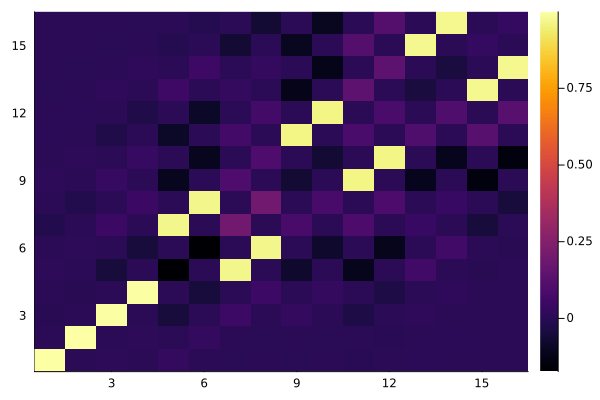

In [57]:
prop = snap_disp_classic_gate([-0.2336736463421616, 0.3669181173739397, 0.23367351861916116, 2.7884901750719577, 3.473215132018274, -2.798740120735896, 0.3535661925951218, 0.2729337101729005, 2.4930916138269876, 2.559441485541238, 0.7091485241335252, -2.7944345471624694, 1.0319374895582125, -2.1004296808769443, -2.116032008122913, 1.1063092045268517, -4.255451376762533, -1.1802232907089818, -2.4715199226985183, 1.883573183371793, -2.5253288264113003, -2.598390890685875, -2.5841992957654143, 4.292139197530038, 3.093112107594174, -3.4869741238804415, 4.589026819714911], X_gate, N * 2, 3,disp,snap)
prop = prop * exp(-im*angle(prop[1, 1]))
heatmap(real(prop))

In [48]:
function half_snap_disp_classic(coefficients, unitary, N, blocks,disp,snap)

    αsi = coefficients[1: blocks]
    βsi = coefficients[blocks + 1: 2*blocks]
    θs = coefficients[2*blocks + 1 : end]
    propagator = Matrix{ComplexF64}(I,N,N)
    q_d = Int(N/4)
    zero = zeros(q_d)

    for i in 1:blocks
        params_snap_1 = [θs[(i - 1) * q_d + 1 : i * q_d]..., zero...]
        params_snap_2 = [zero..., θs[(i - 1) * q_d + 1 : i * q_d]...]
        propagator = propagator * disp(αsi[i]) * snap(params_snap_1) * disp(βsi[i]) * snap(params_snap_2) 
    end

    return 1 - norm(tr(propagator*unitary') / N)^2
    
end

half_snap_disp_classic (generic function with 1 method)

In [49]:
costs = []
for blocks in 6:1:6
    it_costs = []
    for iteration in 1:20
        println("blocks: ", blocks," iterations :", iteration)
        coefficients_initial = zeros((N + 2 ) * blocks)
        coefficients_initial[1: 2*blocks] = rand(2*blocks)*2 .-1
        coefficients_initial[2*blocks + 1:end] = rand(N*blocks) * 2 * pi .- pi
        f(x) = half_snap_disp_classic(x, X_gate, N * 2, blocks,disp,snap)
        res = Optim.optimize(f, coefficients_initial , LBFGS(), Optim.Options(show_trace=true, show_every=100))
        push!(it_costs,Optim.minimum(res))
        println(Optim.minimum(res))
    end
    println(it_costs)
    println(minimum(it_costs))
    push!(costs,minimum(it_costs))
end

blocks: 6 iterations :1
Iter     Function value   Gradient norm 


     0     9.862944e-01     2.145726e-01
 * time: 0.00011992454528808594


   100     6.915621e-02     2.418288e-02
 * time: 7.316092014312744


   200     4.527489e-02     1.330330e-02
 * time: 14.977731943130493


   300     4.356324e-02     3.213524e-03
 * time: 22.591728925704956


   400     4.343611e-02     2.979457e-04
 * time: 30.090646982192993


   500     4.343414e-02     5.994326e-05
 * time: 38.120534896850586


   600     4.343407e-02     9.093978e-06
 * time: 46.301125049591064


   700     4.343407e-02     1.914436e-06
 * time: 54.7076530456543


   800     4.343407e-02     2.281241e-07
 * time: 63.31516408920288


   900     4.343407e-02     6.050307e-08
 * time: 71.98302292823792


0.043434067041440816
blocks: 6 iterations :2
Iter     Function value   Gradient norm 
     0     9.534162e-01     2.149828e-01
 * time: 7.987022399902344e-5


   100     2.243414e-01     2.481416e-02
 * time: 8.425859928131104


   200     1.382369e-01     1.157577e-02
 * time: 16.478510856628418


   300     1.374686e-01     2.230857e-04
 * time: 25.00109601020813


   400     1.374685e-01     9.369827e-06
 * time: 33.658819913864136


   500     1.374685e-01     3.121775e-07
 * time: 42.392796993255615


0.13746845681398046
blocks: 6 iterations :3
Iter     Function value   Gradient norm 
     0     9.935038e-01     7.865659e-02
 * time: 0.00010013580322265625


   100     1.243774e-01     1.565602e-02
 * time: 8.2678701877594


   200     1.225409e-01     4.523832e-03
 * time: 16.749977111816406


   300     1.222416e-01     1.729301e-03
 * time: 26.81965398788452


   400     1.222363e-01     8.771823e-05
 * time: 36.62342715263367


   500     1.222359e-01     1.625724e-05
 * time: 45.18623399734497


   600     1.222359e-01     9.630127e-06
 * time: 54.25364017486572


   700     1.222358e-01     7.898034e-07
 * time: 62.835875034332275


   800     1.222358e-01     3.076765e-07
 * time: 71.19778203964233


   900     1.222358e-01     1.120224e-07
 * time: 79.76186609268188


0.12223584931896425
blocks: 6 iterations :4
Iter     Function value   Gradient norm 
     0     9.952694e-01     4.119478e-02
 * time: 7.605552673339844e-5


   100     9.555912e-02     6.953678e-02
 * time: 8.201290130615234


   200     3.593235e-02     3.724246e-02
 * time: 16.202325105667114


   300     2.568541e-02     1.593509e-03
 * time: 24.73916792869568


   400     2.567553e-02     4.707576e-05
 * time: 33.40610694885254


   500     2.567551e-02     2.748719e-06
 * time: 41.87327194213867


   600     2.567551e-02     2.498502e-07
 * time: 50.46296501159668


0.02567551240697341
blocks: 6 iterations :5
Iter     Function value   Gradient norm 
     0     9.978587e-01     5.307613e-02
 * time: 6.794929504394531e-5


   100     2.112249e-01     3.015769e-02
 * time: 8.068886995315552


   200     1.537367e-01     2.189672e-02
 * time: 16.647818088531494


   300     1.301712e-01     1.707931e-03
 * time: 25.218465089797974


   400     1.301634e-01     9.831658e-06
 * time: 33.84680414199829


   500     1.301634e-01     5.563808e-07
 * time: 42.70217704772949


0.13016338713385045
blocks: 6 iterations :6
Iter     Function value   Gradient norm 
     0     9.540030e-01     1.498998e-01
 * time: 5.316734313964844e-5


   100     2.004964e-01     8.049625e-02
 * time: 8.07091212272644


   200     1.182224e-01     2.745346e-02
 * time: 16.35892605781555


   300     7.690409e-02     1.801888e-02
 * time: 24.77714204788208


   400     5.143629e-02     3.014844e-03
 * time: 33.27541208267212


   500     5.078587e-02     1.885888e-03
 * time: 41.92827320098877


   600     5.031941e-02     9.624492e-03
 * time: 50.78095507621765


   700     5.003238e-02     1.368800e-03
 * time: 59.32821798324585


   800     4.993375e-02     4.112202e-04
 * time: 67.60261416435242


   900     4.993115e-02     1.064066e-04
 * time: 76.29575204849243


  1000     4.993101e-02     3.592154e-05
 * time: 85.26824903488159


0.04993101222584162
blocks: 6 iterations :7
Iter     Function value   Gradient norm 
     0     9.753918e-01     8.453721e-02
 * time: 7.414817810058594e-5


InterruptException: InterruptException:

# Stab analysus

In [11]:
coeffs = [0.017884908596753374, -0.13628732544332808, -0.3218772701511258, -0.10750476184579687, 0.1746376092236177, 0.4155865032847695, -1.6350872800733443, -3.12109196342535, -0.45612409791455577, 2.0116501973309284, 0.10932375671231553, 0.8119046622844536, 3.2317407839277106, -0.8971036929588493, -0.06088402066338666, -2.8327006381639626, 0.9670135231941518, -0.903160544623486, -2.752389284474736, 1.5898127552299108, -2.7142209074538037, -1.5977736721451854, 0.1847462414593341, 0.766126631754709, 2.800139464396899, 4.775584060051256, -0.5253575654318168, -3.9116794568387627, -0.700169013016735, 1.6705051658106496, 1.1514333622548285, 0.4136144380007062, 3.1142258740075768, 2.655226585748261, -4.072586893197658]
f(x) = snap_disp_cost_gate(x, X_gate, N * 2, 5,disp,snap)
println(f(coeffs))

opt_perturbed = ComplexF64[]

for coeff in coeffs
    perturbed = coeff + (rand()*0.002-0.001)
    push!(opt_perturbed,perturbed)
end

f(opt_perturbed)

8.068103015679284e-6


3.166346297578393e-5